In [1]:
import importlib
import pickle
from pathlib import Path
import sys
import dill
import matplotlib.colors as colors
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from scipy.spatial import KDTree
from scipy.stats._continuous_distns import norm
from sklearn.metrics.pairwise import euclidean_distances
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.stats import gaussian_kde
from matplotlib.lines import Line2D

import mstme.exposure_series as es
import mstme.mstmeclass as mc
from mstme.mstmeclass import MSTME, SIMSET, STM

In [2]:
from mstme.grapher import _search_isocontour

In [3]:
sys.modules["es"] = es
sys.modules["mc"] = mc
sys.modules["mstmeclass"] = mc
sys.modules["exposure_series"] = es

In [4]:
pos_color = plt.rcParams["axes.prop_cycle"].by_key()["color"]
plt.style.use("./src/plot_style.txt")

In [5]:
ds=xr.load_dataset(f"./data/exp_series/{34:03d}.nc")


In [6]:
import matplotlib.dates as mdates

In [7]:
Path(f"F://exp_series/000.nc").exists()

True

# Load data

In [6]:
simset = SIMSET("guadeloupe-wide", "h-east", -100)
thr_pct_mar = 60
thr_pct_com = 90


In [7]:

# get stm from previous result
path_condition = Path(f"./output-new/{simset.region}/{simset.rf}/GP{thr_pct_mar}%_CM{thr_pct_com}%_100subsamples")
with open(path_condition / "mstme_condition.dill", "rb") as f:
    mstme:MSTME = pickle.load(f)
stm = mstme.stm
num_events = mstme.num_events
num_vars = mstme.num_vars

# load in one dataset for filtering NaNs
_ds = xr.open_dataset(f"F://exp_series/000.nc")
_ds = _ds.dropna(dim='node')
_, latitude, longitude = _ds.coords.values()
tree = KDTree(np.array([latitude,longitude]).T)
grid_res = 10
lat_list = np.linspace(simset.min_lat, simset.max_lat, grid_res)
lon_list = np.linspace(simset.min_lon, simset.max_lon, grid_res)
grid_latlon_list = np.array(np.meshgrid(lat_list,lon_list)).reshape((2,grid_res**2)).T
dist_list, pos_list = tree.query(grid_latlon_list)
pos_list = pos_list.flatten()
mask = mstme.mask
paths = [Path(f"F://exp_series/{i:03d}.nc") for i in mask.nonzero()[0]]
ds_exp_series = es.load_data(paths, mask, pos_list)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [8]:
simset = SIMSET("guadeloupe-wide", "h-east", -100)


In [48]:
len(ds_exp_series)

467

In [9]:
_, pos_list_5loc = KDTree(np.array([latitude[pos_list],longitude[pos_list]]).T).query(    [
        [16.5,-61.8],
        [16.0,-61.9],
        [16.05,-61.4],
        [16.0,-61.0],
        [16.5,-61.1],
    ])

In [10]:
res = 10
di = 0
dist_method = ["md", "hausdorff"]
use_temporal = True
mask_type = 'none'
mask_threshold = 0.2

# Kendall tau

In [ ]:
ds_exp_series

In [ ]:
importlib.reload(es)

<module 'mstme.exposure_series' from 'j:\\mstme\\src\\mstme\\exposure_series.py'>

In [ ]:
mstme.num_nodes

6704

In [ ]:
importlib.reload(es)

<module 'exposure_series' from 'J:\\mstme\\src\\exposure_series.py'>

In [11]:
subdir = f"dm/{dist_method[di]}_temporal_{use_temporal}_mask_{mask_type}_avg_kendalltau"
if mask_type=='square': subdir+=f"_thr_{mask_threshold:.2f}"
path_out = path_condition/ subdir
if not path_out.exists():
    path_out.mkdir(parents=True, exist_ok=True)

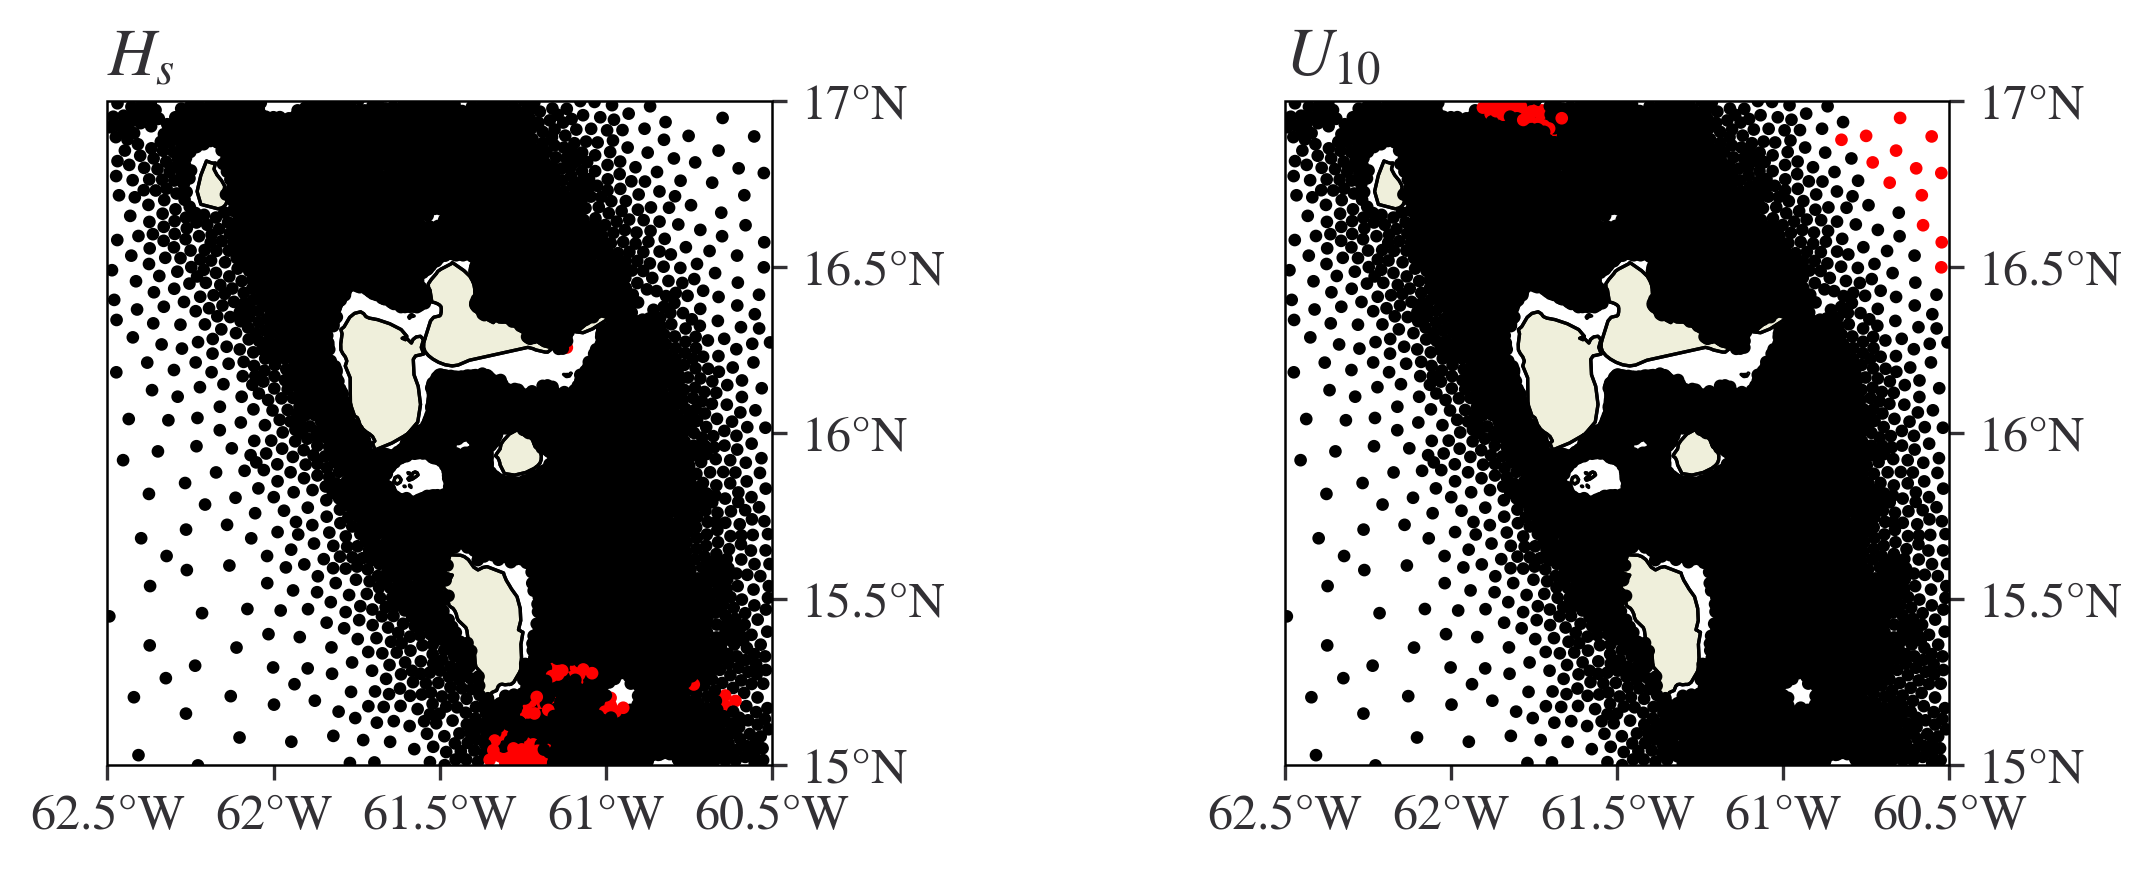

In [ ]:
import mstme.grapher as grapher
fig, ax = plt.subplots(
    1,
    num_vars,
    sharey=True,
    figsize=(4 * mstme.num_vars, 3),
    facecolor="white",
    subplot_kw={"projection": ccrs.PlateCarree()},
)

for S in STM:
    vi = S.idx()
    var_name_i = S.name()
    ax[vi] = grapher.custom_map(ax[vi], mstme.area)
    # _c = ["red" if p < 0.05 else "black" for p in pval_array[vi]]
    _c = ["red" if p < 0.05 else "black" for p in mstme.pval[vi, vi, :]]
    im = ax[vi].scatter(
        # longitude[pos_list],
        # latitude[pos_list],
        mstme.latlon[:, 1],
        mstme.latlon[:, 0],
        s=5,
        c=_c,
    )
    ax[vi].set_title(rf"{var_name_i}")
fig.tight_layout()
plt.savefig(path_out / f"pval_map.png", bbox_inches="tight")
plt.savefig(path_out / f"pval_map.pdf", bbox_inches="tight")

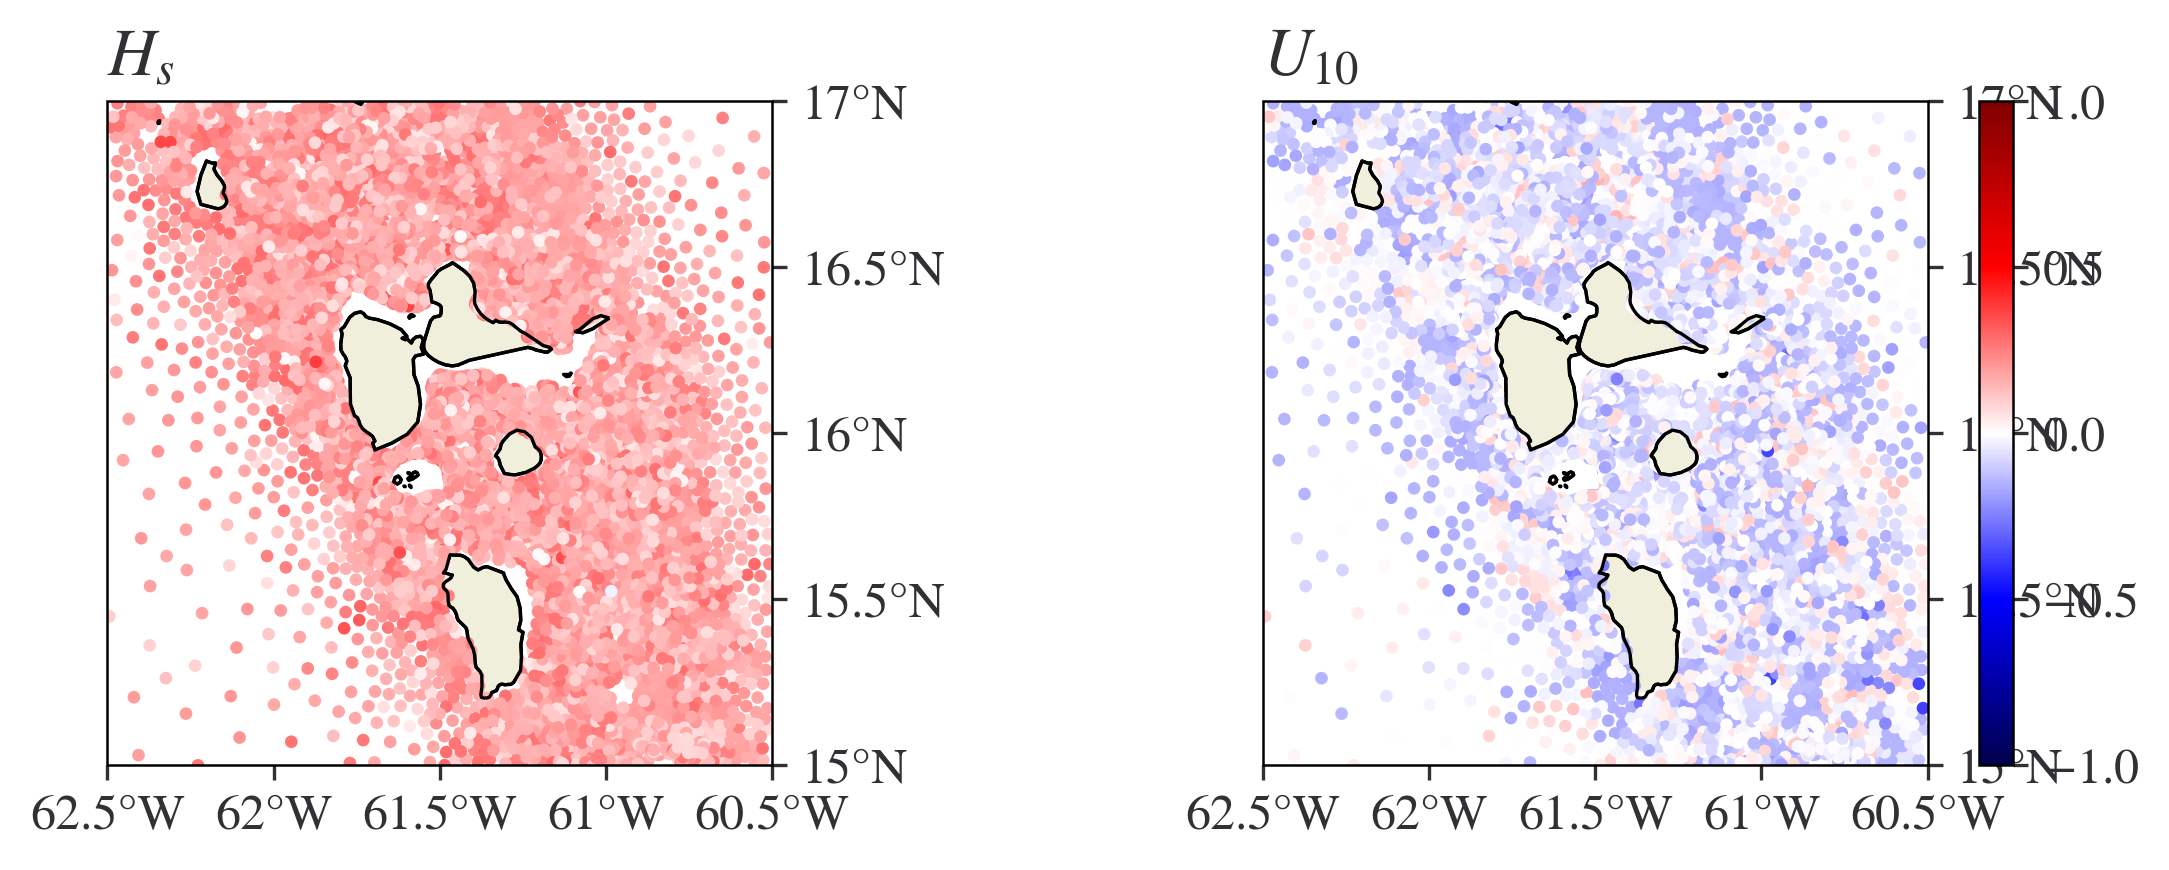

In [ ]:
fig, ax = plt.subplots(
    1,
    num_vars,
    sharey=True,
    figsize=(4 * mstme.num_vars, 3),
    facecolor="white",
    subplot_kw={"projection": ccrs.PlateCarree()},
)

for S in STM:
    vi = S.idx()
    var_name_i = S.name()
    ax[vi] = grapher.custom_map(ax[vi], mstme.area)
    # _c = ["red" if p < 0.05 else "black" for p in pval_array[vi]]
    _c = ["red" if p < 0.05 else "black" for p in mstme.pval[vi, vi, :]]
    im = ax[vi].scatter(
        # longitude[pos_list],
        # latitude[pos_list],
        mstme.latlon[:, 1],
        mstme.latlon[:, 0],
        s=5,
        c=tau_array[vi],
        cmap='seismic',
        vmin=-1,
        vmax=1,
    )
    ax[vi].set_title(rf"{var_name_i}")
fig.tight_layout()
plt.colorbar(im, ax=ax[1])
plt.savefig(path_out / f"tval_map.png", bbox_inches="tight")
plt.savefig(path_out / f"tval_map.pdf", bbox_inches="tight")

# Compare wind wave 2D histogram from original and subsample

In [14]:
importlib.reload(mc)

<module 'mstme.mstmeclass' from 'e:\\documents\\copy of mstme drive\\mstme\\src\\mstme\\mstmeclass.py'>

In [12]:
path_mstme = Path(
    f"./output-new/{simset.region}/{simset.rf}/GP{thr_pct_mar}%_CM{thr_pct_com}%_{100}subsamples/mstme_condition.dill"
)
with open(path_mstme, "rb") as f:
    mstme_condition: MSTME = dill.load(f)
N_year_pool = 200
N_subsample = 1000
path_mstme_ss_dill = path_mstme.parent.joinpath(
    f"mstme_ss_{N_subsample}_pool_{N_year_pool}.dill"
)
if path_mstme_ss_dill.exists():
    with open(path_mstme_ss_dill, "rb") as f:
        tm_MSTME_ss, stm_MSTME_ss = dill.load(f)
    if tm_MSTME_ss.shape[0] != N_subsample:
        print(
            f"Sample count of {tm_MSTME_ss.shape[0]} for mstme_ss_dill does not match the input:{N_subsample} (GP{round(thr_pct_mar*100)}%_CM{round(thr_pct_com*100)}%)"
        )
else:
    try:
        tm_MSTME_ss, stm_MSTME_ss = mc.subsample_MSTME(
            mstme_condition,
            N_subsample,
            N_year_pool,
            pos_list=pos_list,
        )
        with path_mstme_ss_dill.open("wb") as f:
            dill.dump((tm_MSTME_ss, stm_MSTME_ss), f)
    except mc.SubsampleException as e:
        print(e)

rng = np.random.default_rng()


In [13]:
def draw_contour_comparison_random_subsample(loc_i, res=25):
    num_events_ext = np.count_nonzero(mstme.is_e_any)
    exp_series_ext = [
        ds_exp_series[idx].isel(node=pos_list_5loc[loc_i])[["hs", "UV_10m"]]
        for idx in np.where(mstme.is_e_any)[0]
    ]
    stm_ext = mstme.stm[:, mstme.is_e_any]
    exp_array, exp_unique = es.quantize_exp(
        exp_series_ext, num_events_ext, res, use_temporal
    )
    exp_array *= es.get_mask(res, {"type": mask_type, "threshold": mask_threshold})
    tdata = []
    for i in range(100 * num_events_ext):
        ssi = rng.choice(1000)
        _stm = rng.choice(stm_MSTME_ss[ssi, :, :], size=1, axis=1)
        _idx = rng.choice(num_events_ext)
        _exp_traj = exp_series_ext[_idx].to_array().values
        _tdata = _stm * _exp_traj
        tdata.append(_tdata)
        
    fig, axes = plt.subplots(1, 3, figsize=(4 * 3, 3), facecolor="white")

    bounds = [[0, 20], [0, 50]]
    axes[0].set_xlabel(STM.H.name())
    axes[0].set_ylabel(STM.U.name())
    axes[0].set_title("Ground truth estimate")
    x_original = []
    y_original = []
    for ei in range(num_events_ext):
        x_original.extend(exp_series_ext[ei]["hs"].values.tolist() * stm_ext[0, ei].values)
        y_original.extend(exp_series_ext[ei]["UV_10m"].values.tolist() * stm_ext[1, ei].values)
    h, xedges, yedges, image = axes[0].hist2d(
        x_original,
        y_original,
        density=True,
        range=bounds,
        # cmax=1e2
        norm=colors.LogNorm(1e-5, 1e0),
    )
    plt.colorbar(image, ax=axes[0])

    axes[1].set_xlabel(STM.H.name())
    axes[1].set_ylabel(STM.U.name())
    axes[1].set_xlim(0, 25)
    axes[1].set_ylim(0, 60)
    axes[1].set_title("MSTM-TE")
    x_TE = []
    y_TE = []
    for td in tdata:
        x_TE.extend(td[0])
        y_TE.extend(td[1])
    h, xedges, yedges, image = axes[1].hist2d(
        x_TE,
        y_TE,
        density=True,
        range=bounds,
        # cmax=1e2
        norm=colors.LogNorm(1e-5, 1e0),
    )
    plt.colorbar(image, ax=axes[1])


    axes[2].set_xlabel(STM.H.name())
    axes[2].set_ylabel(STM.U.name())
    axes[2].set_title("Contour comparison")
    nbins = res
    xi, yi = np.mgrid[0 : 20 : nbins * 1j, 0 : 50 : nbins * 1j]
    levels = [10**i for i in np.arange(-5, 0, 1.0)]

    kde1 = gaussian_kde(np.array([x_original, y_original]))
    zi = kde1(np.vstack([xi.flatten(), yi.flatten()]))
    im1 = axes[2].contour(
        xi,
        yi,
        zi.reshape(xi.shape),
        norm=colors.LogNorm(1e-5, 1e0),
        levels=levels,
        # colors='black',
    )

    kde2 = gaussian_kde(np.array([x_TE, y_TE]))
    zi = kde2(np.vstack([xi.flatten(), yi.flatten()]))
    im2 = axes[2].contour(
        xi,
        yi,
        zi.reshape(xi.shape),
        norm=colors.LogNorm(1e-5, 1e0),
        levels=levels,
        linestyles="--",
        # colors='red',
    )
    axes[2].clabel(im2, inline=True, fontsize=5, fmt="%1.0e")

    plt.savefig(path_out / f"MSTM-TE_comparison_{loc_i}_kde.png", bbox_inches="tight")
    plt.savefig(path_out / f"MSTM-TE_comparison_{loc_i}_kde.pdf", bbox_inches="tight")

In [13]:
mstme_condition.sample_stm(N_sample=1)
mstme_condition.exp_sample()

array([[15.74322156],
       [60.98308471]])

211

In [14]:
exp_series = ds_exp_series[rng.choice(np.where(mstme_condition.is_e_any)[0],size=1)[0]]
mstm = mc.sample_stm(mstme_condition,N_sample=1)
tc=[]
tc.append(exp_series["hs"].values.tolist() * mstm[0])
tc.append(exp_series["UV_10m"].values.tolist() * mstm[1])

In [36]:
exp_series

<xarray.Dataset>
Dimensions:    (time: 283, node: 100)
Coordinates:
  * time       (time) datetime64[ns] 2000-06-02T21:00:00 ... 2000-06-08T18:00:00
    latitude   (node) float32 10.97 16.51 14.26 14.27 ... 14.9 12.37 18.1 17.69
    longitude  (node) float32 -75.33 -61.49 -60.7 ... -61.08 -62.95 -76.77
Dimensions without coordinates: node
Data variables:
    UV_10m     (time, node) float32 0.004288 0.01942 0.02598 ... 0.2078 0.07768
    hs         (time, node) float32 0.0 0.0 0.0 0.0 ... 0.0592 0.06674 0.01451
Attributes:
    title:        WW3
    institution:  WW3 2 UGRID (BRGM)
    source:       WW3 - Projet Carib-Coast
    references:   WW3 WIKI
    Conventions:  CF-1.6, UGRID-1.0

In [39]:
tc[0].shape

(283, 100)

In [40]:
plt.plot(tc[0][:,nni],tc[1,:nni])

NameError: name 'nni' is not defined

In [71]:
mc.sample_stm(mstme_condition,N_sample=1)[0]

array([23.21381414])

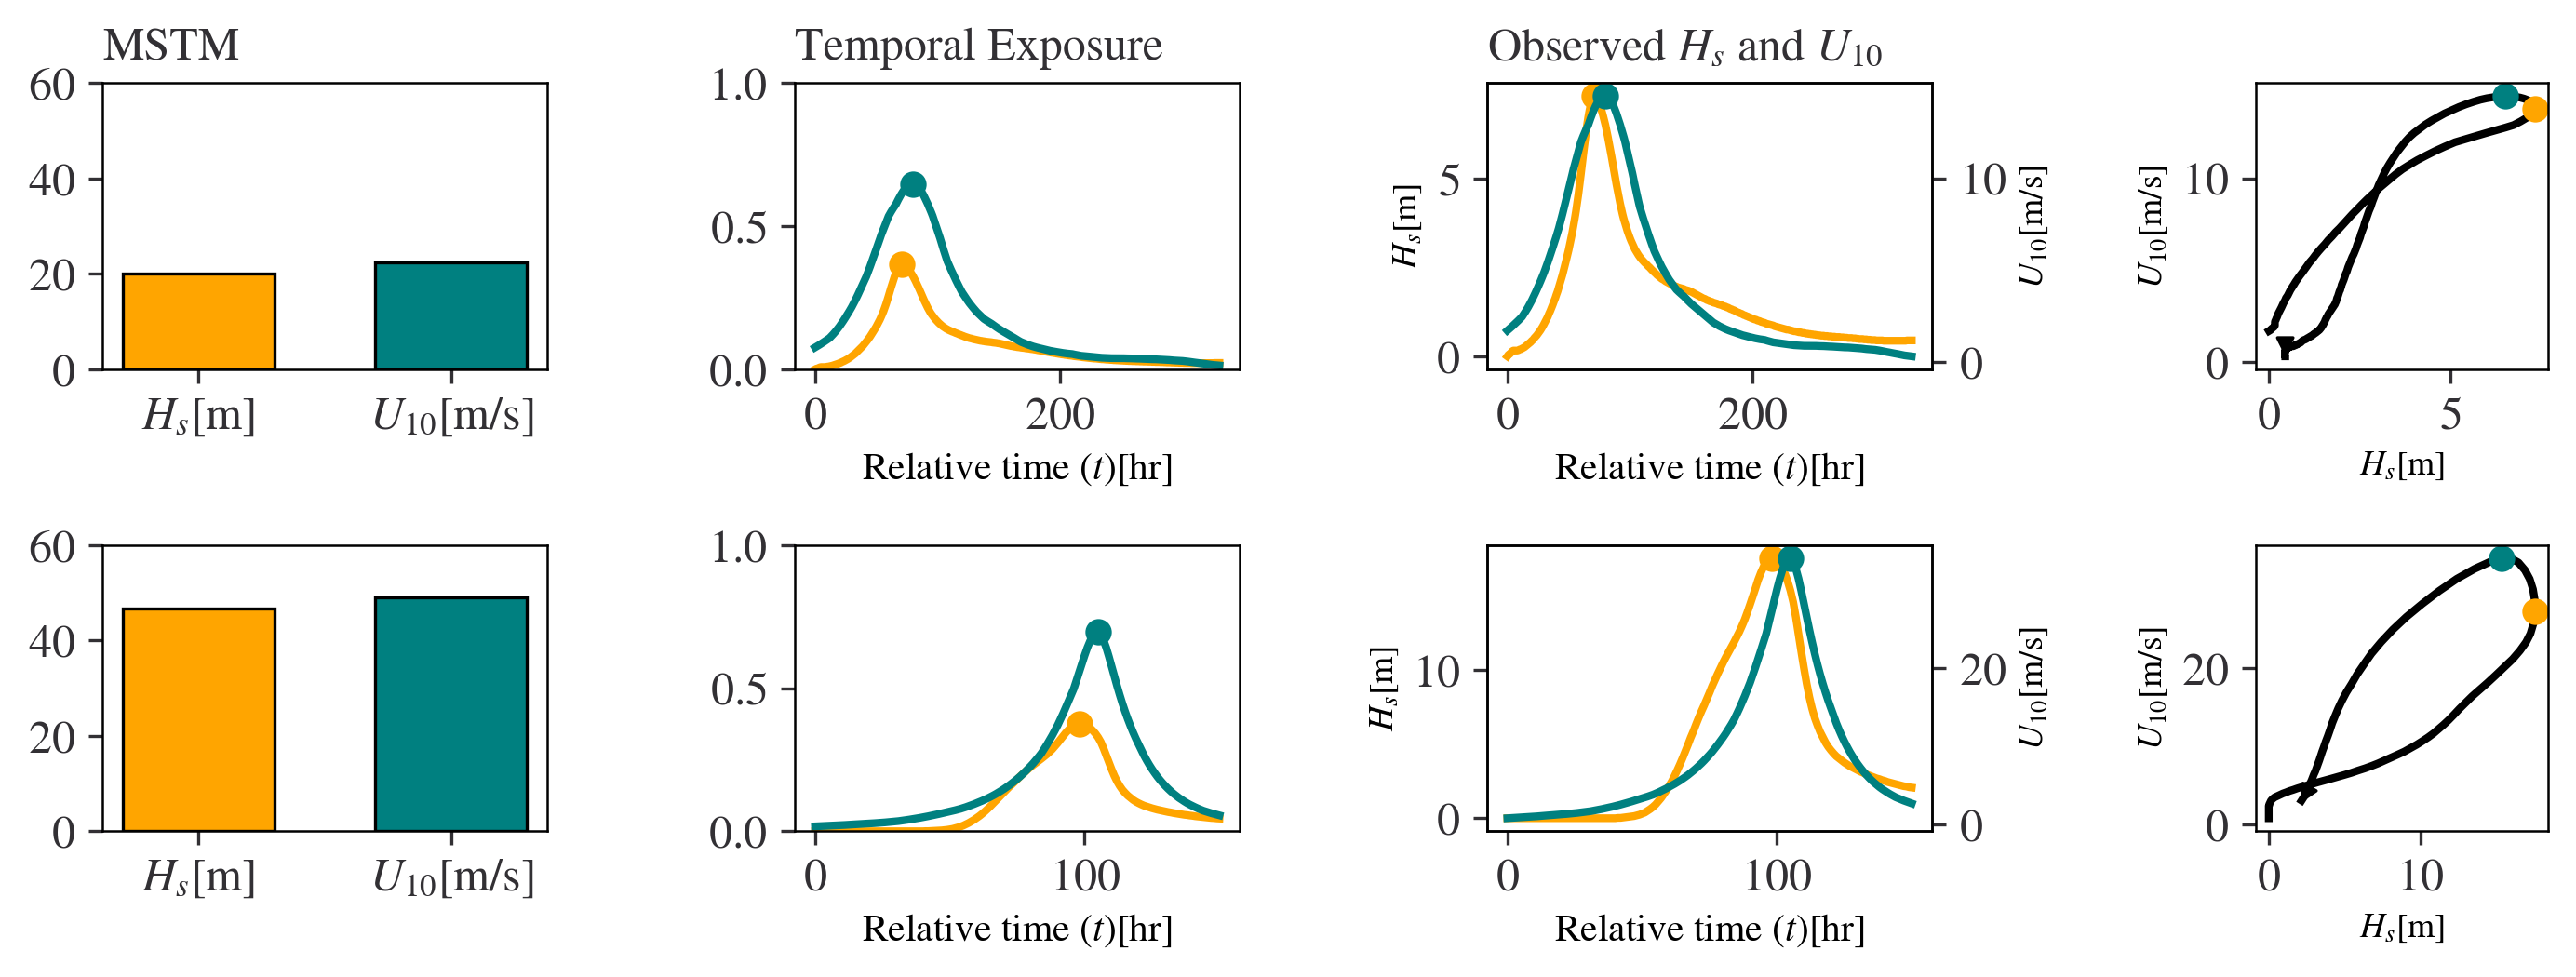

In [19]:
# pos_list_pwe = [4567,5006,5923,6078,6111]
# pos_list_pwe = [5006,6078,6111]
n_cyclones = 2
fig, axes = plt.subplots(
    n_cyclones,
    4,
    figsize=(4 * 4*0.6, 3 * n_cyclones*0.6),
    squeeze=False,
)
fig.subplots_adjust(hspace=0.5, wspace=0.5)
# mstm_list = mstme_condition.stm.data[:, 0:3].T
mstm_list = mc.sample_stm(mstme_condition,N_sample=n_cyclones)
title_size=12
axes[0, 0].set_title("MSTM",size=title_size)
axes[0, 1].set_title("Temporal Exposure",size=title_size)
axes[0, 2].set_title("Observed $H_s$ and $U_{10}$",size=title_size)
for i in range(n_cyclones):
    # ds = xr.load_dataset(f"./data/exp_series/{i+3:03d}.nc")
    ni = pos_list_5loc[1]
    ds = ds_exp_series[rng.choice(np.where(mstme_condition.is_e_any)[0],size=1)[0]]
    t = ds["time"]
    x = np.arange(t.size)
    yh = ds["hs"].isel(node=ni)
    yu = ds["UV_10m"].isel(node=ni)
    idx_h = yh.argmax()
    idx_u = yu.argmax()
    mstm = mstm_list[i]

    ##
    axes[i, 0].set_ylim(0, 60)
    axes[i, 0].bar(
        [f"{STM.H.name()}[m]", f"{STM.U.name()}[m/s]"],
        height=mstm,
        width=0.6,
        color=["orange", "teal"],
    )

    ##
    axes[i, 1].set_ylim(0, 1)
    axes[i, 1].plot(x, yh, c="orange", label=STM.H.name())
    axes[i, 1].plot(x, yu, c="teal", label=STM.U.name())

    axes[i, 1].scatter(x[idx_h], yh[idx_h], c="orange")
    axes[i, 1].scatter(x[idx_u], yu[idx_u], c="teal")

    axes[i, 1].set_xlabel(r"Relative time ($t$)[hr]",size=10)
    axes[i, 2].plot(x, mstm[0] * yh, c="orange", label=STM.H.name())
    ax2 = axes[i, 2].twinx()
    ax2.plot(x, mstm[1] * yu, c="teal", label=STM.U.name())

    axes[i, 2].scatter(x[idx_h], mstm[0] * yh[idx_h], c="orange")
    ax2.scatter(x[idx_u], mstm[1] * yu[idx_u], c="teal")


    axes[i, 2].tick_params(
        axis="x",  # changes apply to the x-axis
        which="both",  # both major and minor ticks are affected
        top=False,  # ticks along the top edge are off

    )
    axes[i, 2].set_ylabel(f"{STM.H.name()}[{STM.H.unit()}]",size=9)
    axes[i, 2].set_xlabel(r"Relative time ($t$)[hr]",size=10)
    ax2.set_ylabel(f"{STM.U.name()}[{STM.U.unit()}]",size=9)


    # axes[i,3].set_xlim(0, mstm[0])
    # axes[i,3].set_ylim(0, mstm[1])
    axes[i,3].plot(mstm[0] * yh[:-3], mstm[1] * yu[:-3], c="k", zorder=-1)
    axes[i,3].annotate(
        "",
        xy=(mstm[0] * yh[-1], mstm[1] * yu[-1]),
        xytext=(mstm[0] * yh[-3], mstm[1] * yu[-3]),
        arrowprops=dict(arrowstyle="-|>", fc="k"),
    )
    axes[i,3].scatter(mstm[0] * yh[idx_h], mstm[1] * yu[idx_h], c="orange")
    axes[i,3].scatter(mstm[0] * yh[idx_u], mstm[1] * yu[idx_u], c="teal")
    axes[i,3].set_aspect(axes[i,3].get_xlim()[1]/axes[i,3].get_ylim()[1])
    axes[i,3].set_xlabel(f"{STM.H.name()}[{STM.H.unit()}]",size=9)
    axes[i,3].set_ylabel(f"{STM.U.name()}[{STM.U.unit()}]",size=9)
fig.tight_layout()
plt.savefig(f"./output-new/common/example_{n_cyclones}_events_simulated.png", bbox_inches="tight")
plt.savefig(f"./output-new/common/example_{n_cyclones}_events_simulated.pdf", bbox_inches="tight")

In [30]:
_num_events_sample = 10000
ds_exp_series_ext = [ds_exp_series[i] for i in np.where(mstme_condition.is_e_any)[0]]
mstm_sample=mc.sample_stm(mstme_condition,N_sample=_num_events_sample)
# te_sample=rng.choice(ds_exp_series_ext,size=_num_events_sample)
ni = pos_list_5loc[1]
mstmte_list = []
mstme_list = []
for i in range(_num_events_sample):
    te_sample = ds_exp_series_ext[rng.choice(len(ds_exp_series_ext))]
    te = te_sample[["hs","UV_10m"]].isel(node=ni).to_array().values
    mstmte = te*mstm_sample[:,i][np.newaxis].T 
    mstme = np.max(mstmte,axis=1)
    mstmte_list.append(mstmte)
    mstme_list.append(mstme)
mstme_array = np.array(mstme_list)
_exceedance_prob = 1 - mstme_condition.thr_pct_com
_count_sample = round(
    _num_events_sample
    / (100 * mstme_condition.occur_freq * _exceedance_prob)
)
_count_95 = round(
    _num_events_sample
    / (95 * mstme_condition.occur_freq * _exceedance_prob)
)
_count_105 = round(
    _num_events_sample
    / (105 * mstme_condition.occur_freq * _exceedance_prob)
)

In [31]:
mstme_count=[]
for i in range(mstme_array.shape[0]):
    mstme=mstme_array[i,:]
    mstme_count.append(np.count_nonzero(np.all(mstme_array>mstme,axis=1)))
mstme_count = np.array(mstme_count)
is_between = [True if (count>_count_105 and count<_count_95) else False for count in mstme_count]

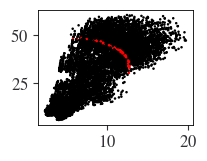

In [24]:
plt.subplots(figsize=(2,1.5),dpi=100)
plt.scatter(mstme_array[:,0],mstme_array[:,1],c=["red" if b else "black" for b in is_between], s=1)

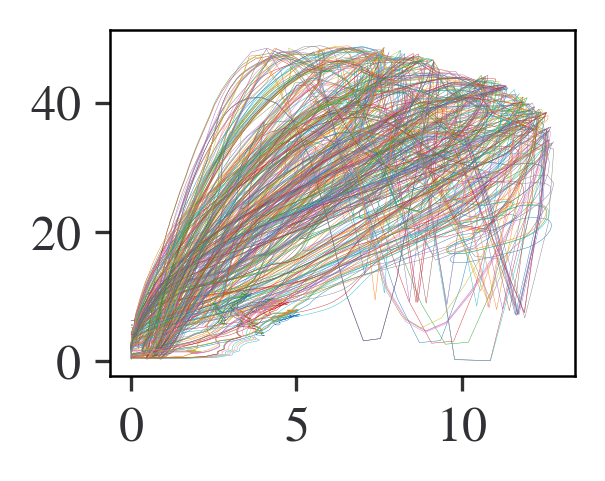

In [176]:
plt.subplots(figsize=(2,1.5),dpi=300)
for i in range(len(mstmte_list)):
    mstmte = mstmte_list[i]
    if is_between[i]:
        plt.plot(mstmte[0],mstmte[1],lw=0.1)

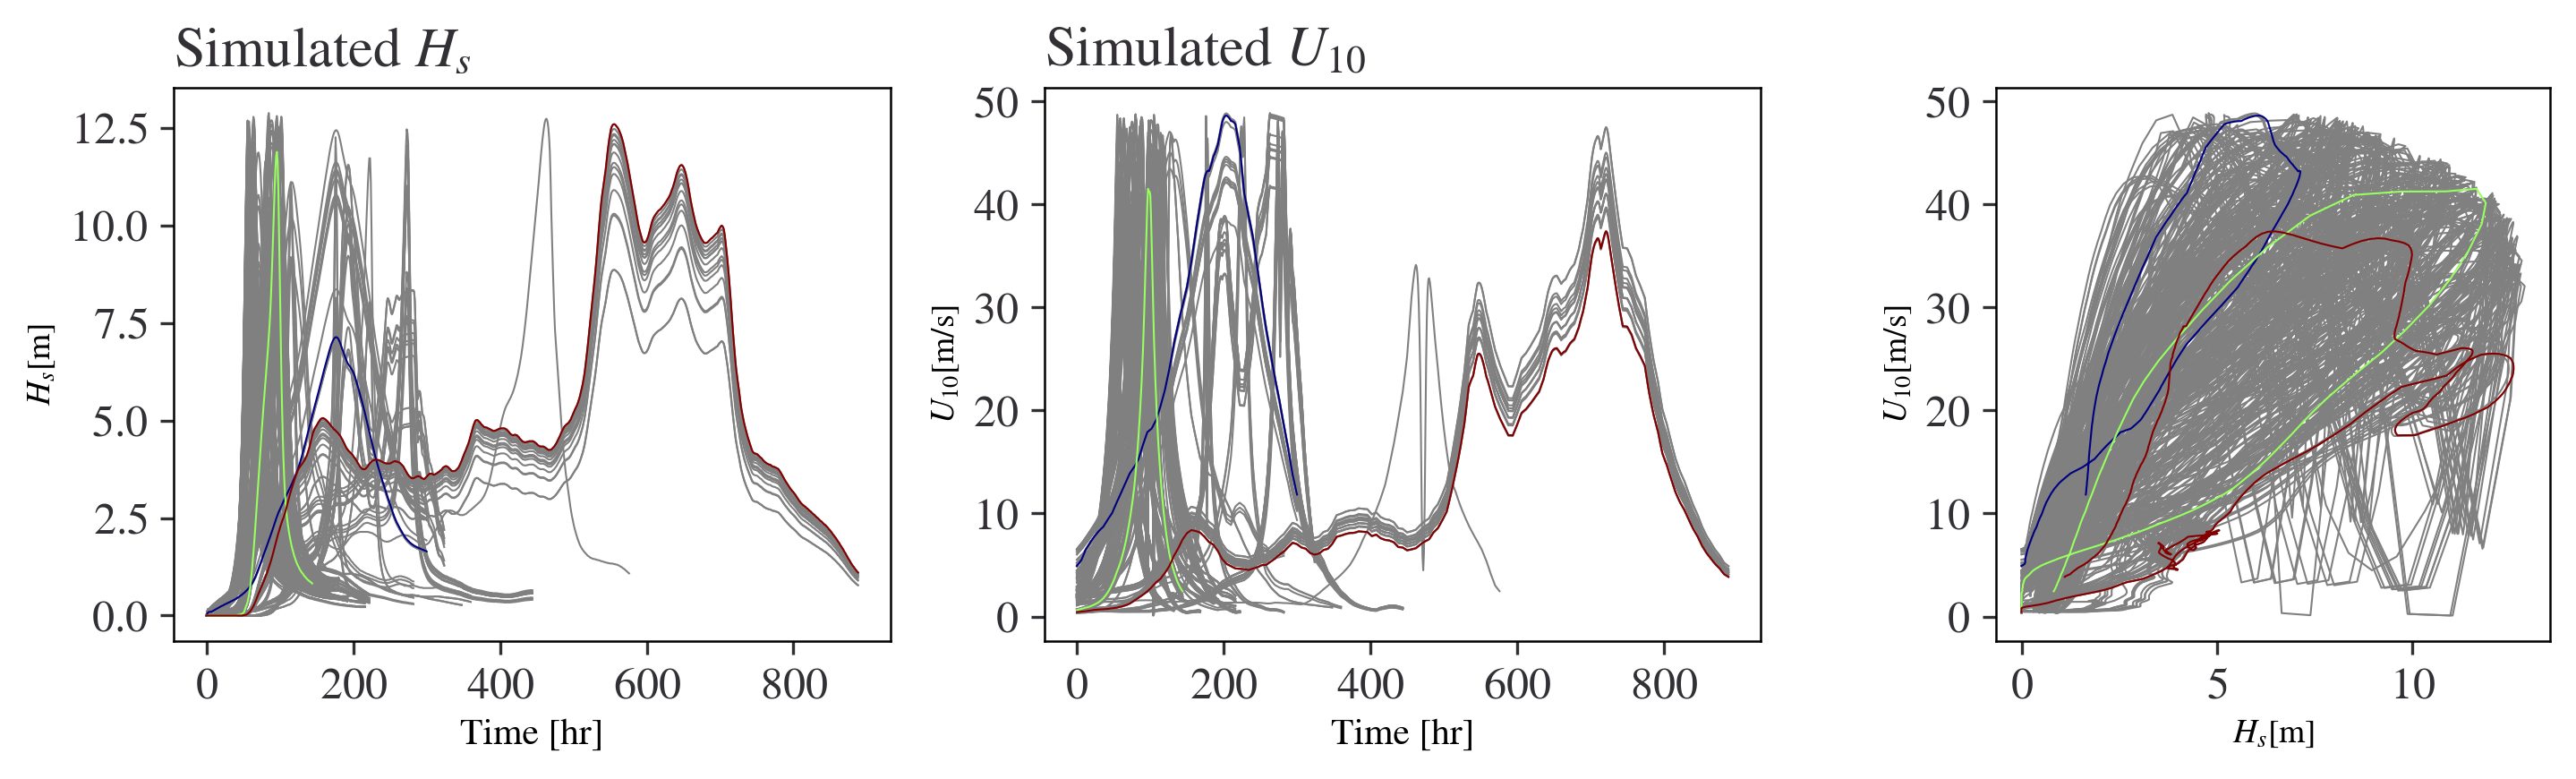

In [33]:
fig, axes = plt.subplots(
    1,
    3,
    figsize=(4 * 2.5 , 3 ),
)
fig.subplots_adjust(hspace=0.5, wspace=0.5)
title_size=15

ni = pos_list_5loc[1]

# ##
# axes[0].set_title("$U_{10}$|($H_s\pm0.5$m of 100-yr RV)",size=title_size*0.8)
# axes[0].hist(
#     mstme_rv100_h[:,1],
#     color="teal",
# )
# axes[0].set_xlabel("$U_{10}$[m/s]",size=9)


axes[0].set_title("Simulated $H_s$",size=title_size)
axes[1].set_title("Simulated $U_{10}$",size=title_size)

idx_is_between = np.where(is_between)[0]
i_colored = idx_is_between[[0,(len(idx_is_between)-1)//2,(len(idx_is_between)-1)]]
for i in range(len(mstmte_list)):
    i_norm = i/len(mstmte_list) 
    mstmte = mstmte_list[i]
    if is_between[i]:
        if i in i_colored:
            color = plt.colormaps["jet"](i_norm)
            zorder=1
        else:
            color = "grey"
            zorder=0
        x = np.arange(0,mstmte.shape[1])
        axes[0].plot(x, mstmte[0], lw=0.5, c=color, label=STM.H.name(),zorder=zorder)
        axes[1].plot(x, mstmte[1], lw=0.5, c=color, label=STM.H.name(),zorder=zorder)
        axes[2].plot(mstmte[0], mstmte[1],lw=0.5, c=color, zorder=zorder)

axes[0].tick_params(
    axis="x",  # changes apply to the x-axis
    which="both",  # both major and minor ticks are affected
    top=False,  # ticks along the top edge are off
)
axes[0].set_ylabel(f"{STM.H.name()}[{STM.H.unit()}]",size=9)
axes[0].set_xlabel(r"Time [hr]",size=10)
axes[1].tick_params(
    axis="x",  # changes apply to the x-axis
    which="both",  # both major and minor ticks are affected
    top=False,  # ticks along the top edge are off
)
axes[1].set_ylabel(f"{STM.U.name()}[{STM.U.unit()}]",size=9)
axes[1].set_xlabel(r"Time [hr]",size=10)

axes[2].set_xlabel(f"{STM.H.name()}[{STM.H.unit()}]",size=9)
axes[2].set_ylabel(f"{STM.U.name()}[{STM.U.unit()}]",size=9)
axes[2].set_aspect(axes[2].get_xlim()[1]/axes[2].get_ylim()[1])

fig.tight_layout()
plt.savefig("./output-new/common/example_events_simulated_100yrRV.png", bbox_inches="tight")
plt.savefig("./output-new/common/example_events_simulated_100yrRV.pdf", bbox_inches="tight")

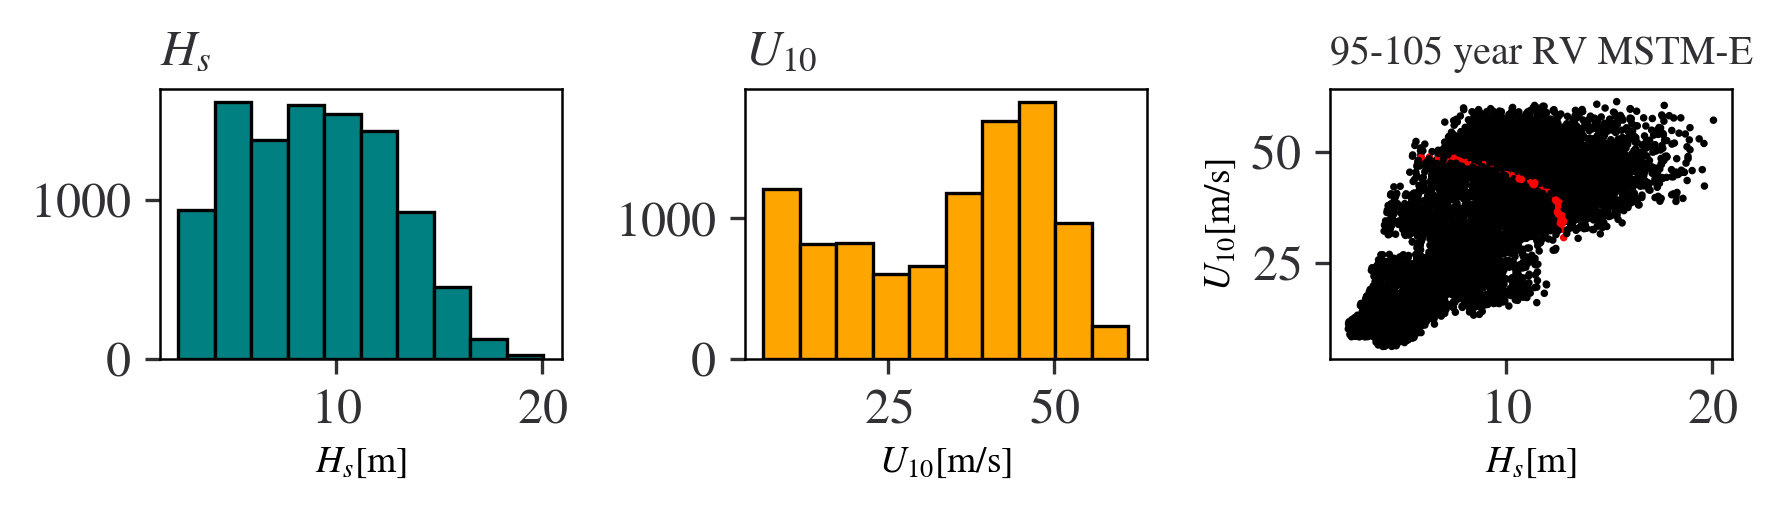

In [200]:
fig, axes = plt.subplots(
    1,
    3,
    figsize=(4 * 2.5 *0.6, 3 *0.6),
)
fig.subplots_adjust(hspace=0.5, wspace=0.5)
title_size=12

ni = pos_list_5loc[1]

##
axes[0].set_title("$H_s$",size=title_size)
axes[0].hist(
    mstme_array[:,0],
    color="teal",
)
axes[0].set_xlabel("$H_s$[m]",size=9)

axes[1].set_title("$U_{10}$",size=title_size)
axes[1].hist(
    mstme_array[:,1],
    color="orange",
)
axes[1].set_xlabel("$U_{10}$[m/s]",size=9)

axes[2].scatter(mstme_array[:,0],mstme_array[:,1],c=["red" if b else "black" for b in is_between], s=1)
axes[2].set_xlabel("$H_s$[m]",size=9)
axes[2].set_ylabel("$U_{10}$[m/s]",size=9)
axes[2].set_title("95-105 year RV MSTM-E",size=title_size*0.8)

plt.tight_layout()
plt.savefig("./output-new/common/example_events_simulated_histogram_100yrRV.png", bbox_inches="tight")
plt.savefig("./output-new/common/example_events_simulated_histogram_100yrRV.pdf", bbox_inches="tight")

In [ ]:
mstme_count[0]

886

In [ ]:
mstmte_ext_list = [mstmte_list[i] for i in ]

In [ ]:
sorted(mstm_sample[0],reverse=True)[round(10000/(mstme_condition.occur_freq*100))]

25.71476400386073

In [ ]:
rv100=[0,0]

In [ ]:
rv100[0] = sorted(mstm_sample[0],reverse=True)[round(10000/(mstme_condition.occur_freq*100))]
rv100[1] = sorted(mstm_sample[1],reverse=True)[round(10000/(mstme_condition.occur_freq*100))]

In [ ]:
rv100

[25.71476400386073, 61.68820772928623]

In [ ]:
mstme_rv100_h=[]
mstme_rv100_u=[]
for mstm in mstm_sample.T:
    if abs(mstm[0]-rv100[0])<0.5: mstme_rv100_h.append(mstm)
    if abs(mstm[1]-rv100[1])<1.0: mstme_rv100_u.append(mstm)
mstme_rv100_h=np.array(mstme_rv100_h)
mstme_rv100_u=np.array(mstme_rv100_u)

In [ ]:
mstme_rv100_u

array([[15.94798061, 61.27898654],
       [20.19174032, 60.82854862],
       [16.37640571, 61.89363217],
       ...,
       [16.23535106, 60.84425249],
       [14.49154161, 61.37013002],
       [13.10674782, 60.81613598]])

In [ ]:
mstme_rv100_h

array([[25.50566886, 56.55775371],
       [25.57658927, 46.7646183 ],
       [25.55016794, 56.51393728],
       [25.32442173, 48.86621176],
       [25.39980042, 53.33250983],
       [25.92376004, 53.25120369],
       [25.39583463, 56.39549289],
       [25.38490398, 52.86397916],
       [25.73238791, 51.22244549],
       [26.05757566, 53.24891045],
       [25.29300278, 54.20581935],
       [25.93844359, 48.62337333],
       [25.32826259, 52.92686164],
       [25.2715071 , 55.67228245],
       [25.48237014, 49.20738796],
       [25.27152011, 46.32739221],
       [26.10530243, 51.38777402],
       [25.62878809, 62.17045753],
       [25.64223262, 53.16057711],
       [25.5899944 , 56.57730672],
       [25.41416221, 53.09348063],
       [25.56616443, 52.27113531],
       [25.66617839, 49.7489731 ],
       [25.59004054, 58.60481426],
       [25.24232297, 48.66100212],
       [25.3109389 , 54.23677899],
       [25.25649323, 48.61448286],
       [25.52309161, 53.2953992 ],
       [25.38774379,

In [ ]:
mstme_rv100_h.shape

(444, 2)

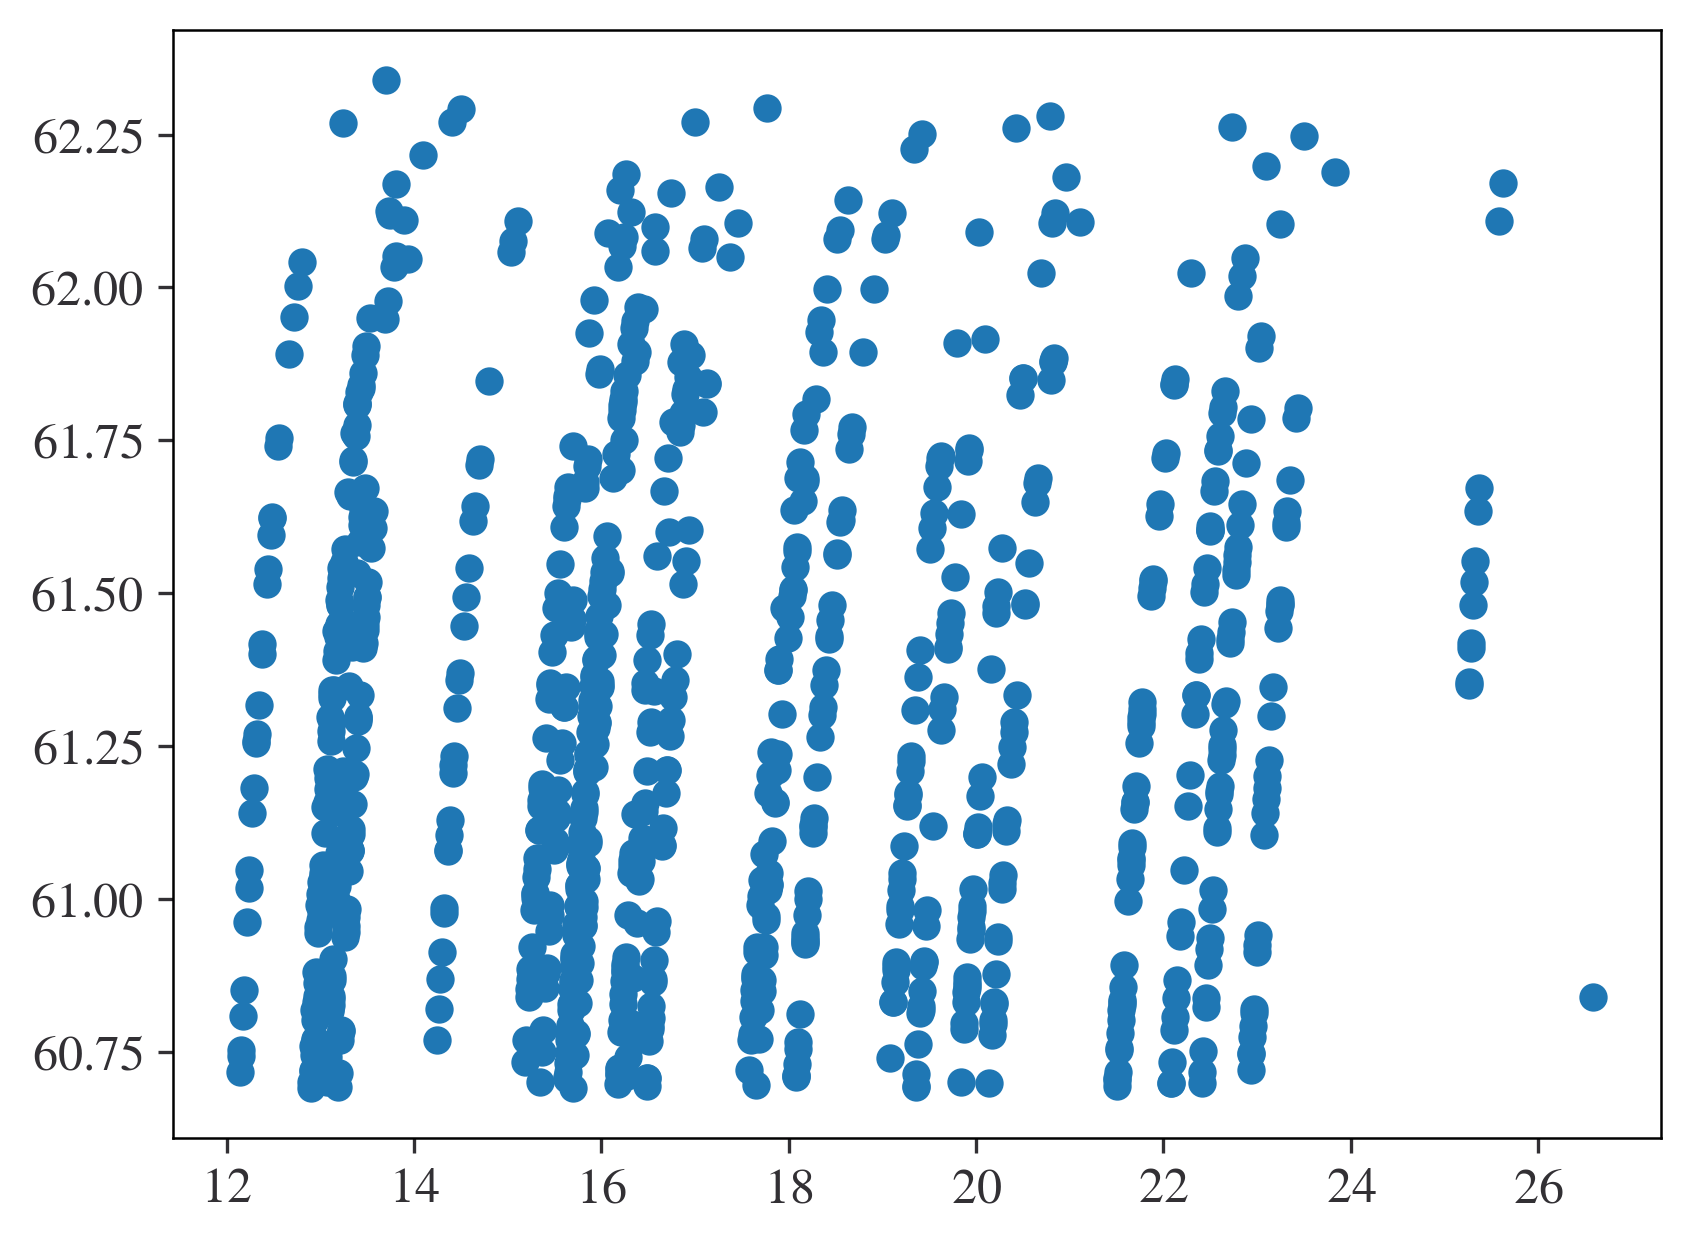

In [ ]:
plt.scatter(mstme_rv100_u[:,0],mstme_rv100_u[:,1])

In [ ]:
np.where(mstme_condition.is_e_any)[0]

array([  5,   7,  21,  22,  33,  41,  55,  65,  67,  71,  83, 111, 118,
       120, 124, 134, 137, 140, 148, 157, 169, 173, 177, 211, 213, 246,
       248, 249, 257, 265, 266, 285, 293, 294, 295, 300, 311, 312, 316,
       332, 340, 357, 365, 438, 443, 449, 454], dtype=int64)

In [ ]:
np.where(mstme_condition.is_e_any)[0]

In [ ]:
ds = []
for i in range(len(ds_exp_series)):
    if np.isin(i,np.where(mstme_condition.is_e_any)[0]):
        ds.append(ds_exp_series[i])

In [ ]:
len(ds)

47

In [ ]:
rng.choice(mstme_rv100_u,size=1)

array([[13.48150537, 61.45821101]])

<>:26: SyntaxWarning: invalid escape sequence '\p'
<>:26: SyntaxWarning: invalid escape sequence '\p'
C:\Users\Kosuke\AppData\Local\Temp\ipykernel_31412\1486843494.py:26: SyntaxWarning: invalid escape sequence '\p'
  axes[0].set_title("$U_{10}$|($H_s\pm0.5$m of 100-yr RV)",size=title_size*0.8)


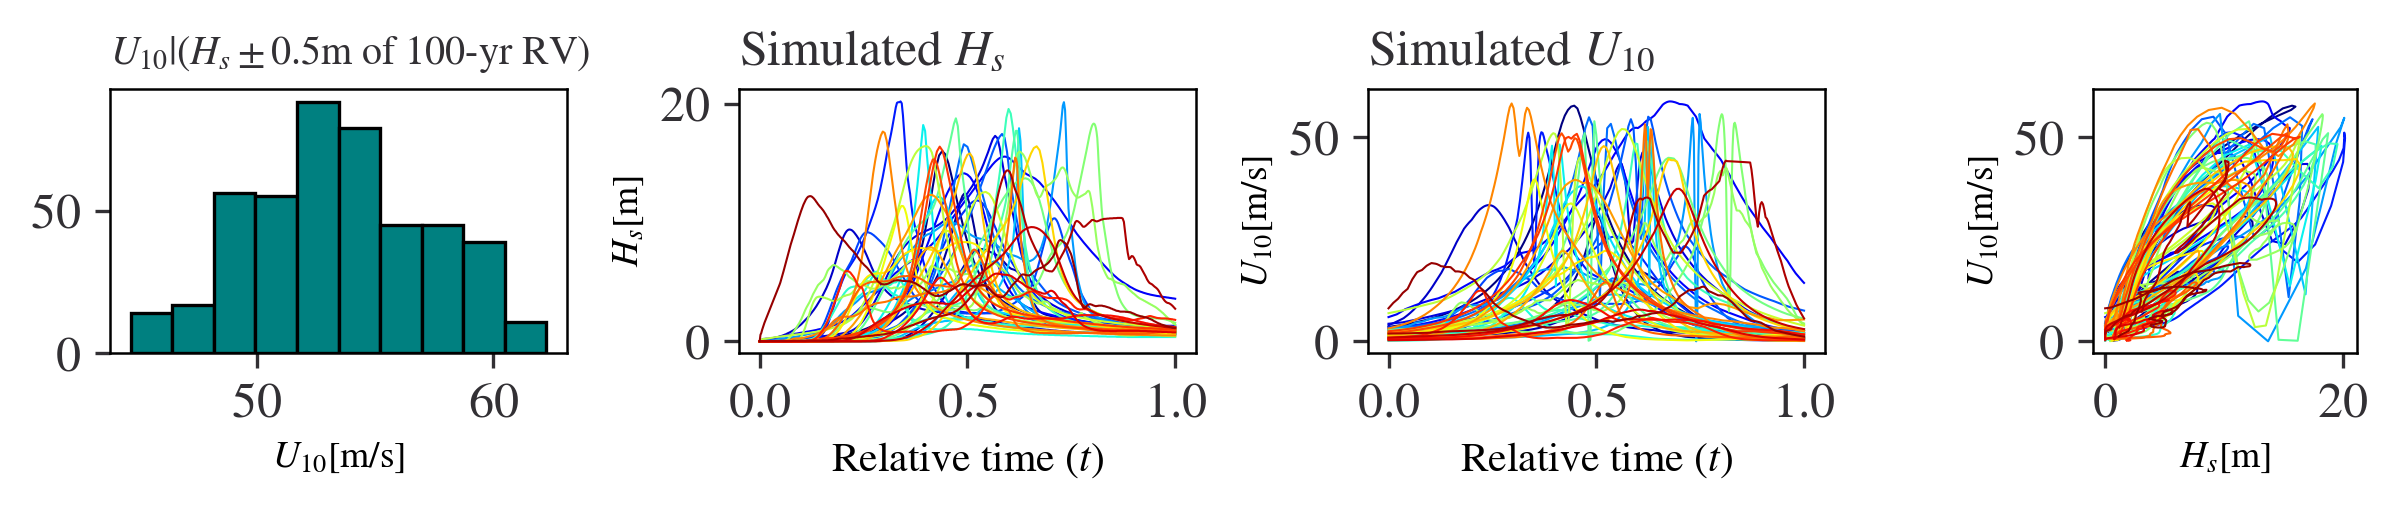

In [ ]:
# pos_list_pwe = [4567,5006,5923,6078,6111]
# pos_list_pwe = [5006,6078,6111]

fig, axes = plt.subplots(
    1,
    4,
    figsize=(4 * 3.5 *0.6, 3 *0.6),
)
fig.subplots_adjust(hspace=0.5, wspace=0.5)
# mstm_list = mstme_condition.stm.data[:, 0:3].T

title_size=12

# ds = xr.load_dataset(f"./data/exp_series/{i+3:03d}.nc")
ni = pos_list_5loc[1]

# ds = ds_exp_series[rng.choice(np.where(mstme_condition.is_e_any)[0],size=1)[0]]
# t = ds["time"]
# x = np.arange(t.size)
# yh = ds["hs"].isel(node=ni)
# yu = ds["UV_10m"].isel(node=ni)
# idx_h = yh.argmax()
# idx_u = yu.argmax()

##
axes[0].set_title("$U_{10}$|($H_s\pm0.5$m of 100-yr RV)",size=title_size*0.8)
axes[0].hist(
    mstme_rv100_h[:,1],
    color="teal",
)
# axes[0].set_ylim(0, 60)
axes[0].set_xlabel("$U_{10}$[m/s]",size=9)

##
# axes[1].set_title("Temporal Exposure",size=title_size)
# axes[1].set_ylim(0, 1)
# axes[1].set_xlabel(r"Time[hr]",size=10)
# for _ds in ds:
#     t = _ds["time"]
#     x = np.arange(t.size)
#     yh = _ds["hs"].isel(node=ni)
#     yu = _ds["UV_10m"].isel(node=ni)
#     idx_h = yh.argmax()
#     idx_u = yu.argmax()
#     axes[1].plot(x, yh,lw=0.5, c="orange", label=STM.H.name())
#     axes[1].plot(x, yu,lw=0.5, c="teal", label=STM.U.name())

##
axes[1].set_title("Simulated $H_s$",size=title_size)
axes[2].set_title("Simulated $U_{10}$",size=title_size)
for i,_ds in enumerate(ds):
    t = _ds["time"]
    x = np.linspace(0,1,t.size)
    # x = np.arange(t.size)
    yh = _ds["hs"].isel(node=ni)
    yu = _ds["UV_10m"].isel(node=ni)
    idx_h = yh.argmax()
    idx_u = yu.argmax()
    _mstm=rng.choice(mstme_rv100_h,size=1)[0]
    axes[1].plot(x, _mstm[0] * yh,lw=0.5, c=plt.colormaps["jet"](i/len(ds)), label=STM.H.name())
    axes[2].plot(x, _mstm[1] * yu,lw=0.5, c=plt.colormaps["jet"](i/len(ds)), label=STM.H.name())
    axes[3].plot(_mstm[0] * yh[:-3], _mstm[1] * yu[:-3],lw=0.5, c=plt.colormaps["jet"](i/len(ds)), zorder=-1)

    # axes[1].scatter(x[idx_h], mstm[0] * yh[idx_h], c="orange")
    # ax2.scatter(x[idx_u], mstm[1] * yu[idx_u], c="teal")
axes[1].tick_params(
    axis="x",  # changes apply to the x-axis
    which="both",  # both major and minor ticks are affected
    top=False,  # ticks along the top edge are off
)
axes[1].set_ylabel(f"{STM.H.name()}[{STM.H.unit()}]",size=9)
axes[1].set_xlabel(r"Relative time ($t$)",size=10)
axes[2].tick_params(
    axis="x",  # changes apply to the x-axis
    which="both",  # both major and minor ticks are affected
    top=False,  # ticks along the top edge are off
)
axes[2].set_ylabel(f"{STM.U.name()}[{STM.U.unit()}]",size=9)
axes[2].set_xlabel(r"Relative time ($t$)",size=10)

# axes[2].set_aspect(mstm[0]/mstm[1])
# axes[2].set_xlim(0, mstm[0])
# axes[2].set_ylim(0, mstm[1])
# axes[2].plot(mstm[0] * yh[:-3], mstm[1] * yu[:-3], c="k", zorder=-1)
# axes[2].annotate(
#     "",
#     xy=(mstm[0] * yh[-1], mstm[1] * yu[-1]),
#     xytext=(mstm[0] * yh[-3], mstm[1] * yu[-3]),
#     arrowprops=dict(arrowstyle="-|>", fc="k"),
# )
# axes[2].scatter(mstm[0] * yh[idx_h], mstm[1] * yu[idx_h], c="orange")
# axes[2].scatter(mstm[0] * yh[idx_u], mstm[1] * yu[idx_u], c="teal")
axes[3].set_xlabel(f"{STM.H.name()}[{STM.H.unit()}]",size=9)
axes[3].set_ylabel(f"{STM.U.name()}[{STM.U.unit()}]",size=9)
axes[3].set_aspect(axes[3].get_xlim()[1]/axes[3].get_ylim()[1])

fig.tight_layout()
plt.savefig("./output-new/common/example_2_events_simulated_100yrH.png", bbox_inches="tight")
plt.savefig("./output-new/common/example_2_events_simulated_100yrH.pdf", bbox_inches="tight")

<>:11: SyntaxWarning: invalid escape sequence '\p'
<>:11: SyntaxWarning: invalid escape sequence '\p'
C:\Users\Kosuke\AppData\Local\Temp\ipykernel_31412\3378083206.py:11: SyntaxWarning: invalid escape sequence '\p'
  axes[0].set_title("$H_s$|($U_{10}\pm1.0$m/s of 100-yr RV)",size=title_size*0.8)


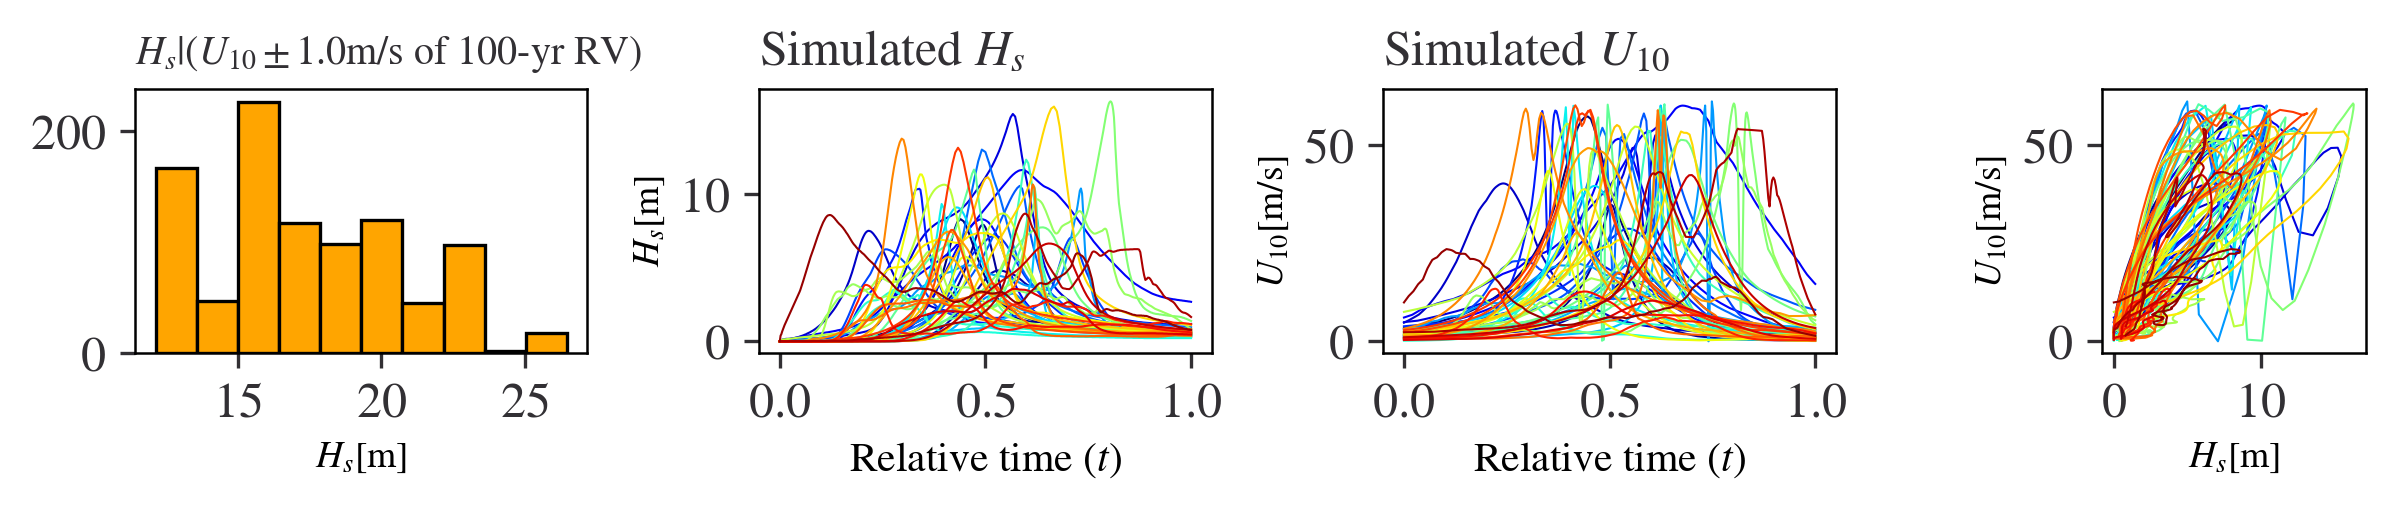

In [ ]:
fig, axes = plt.subplots(
    1,
    4,
    figsize=(4 * 3.5 *0.6, 3 *0.6),
)
fig.subplots_adjust(hspace=0.5, wspace=0.5)

title_size=12
ni = pos_list_5loc[1]
##
axes[0].set_title("$H_s$|($U_{10}\pm1.0$m/s of 100-yr RV)",size=title_size*0.8)
axes[0].hist(
    mstme_rv100_u[:,0],
    color="orange",
)
axes[0].set_xlabel("$H_s$[m]",size=9)
##
axes[1].set_title("Simulated $H_s$",size=title_size)
axes[2].set_title("Simulated $U_{10}$",size=title_size)
for i,_ds in enumerate(ds):
    t = _ds["time"]
    x = np.linspace(0,1,t.size)
    # x = np.arange(t.size)
    yh = _ds["hs"].isel(node=ni)
    yu = _ds["UV_10m"].isel(node=ni)
    idx_h = yh.argmax()
    idx_u = yu.argmax()
    _mstm=rng.choice(mstme_rv100_u,size=1)[0]
    axes[1].plot(x, _mstm[0] * yh,lw=0.5, c=plt.colormaps["jet"](i/len(ds)), label=STM.H.name())
    axes[2].plot(x, _mstm[1] * yu,lw=0.5, c=plt.colormaps["jet"](i/len(ds)), label=STM.H.name())
    axes[3].plot(_mstm[0] * yh[:-3], _mstm[1] * yu[:-3],lw=0.5, c=plt.colormaps["jet"](i/len(ds)), zorder=-1)

axes[1].tick_params(
    axis="x",  # changes apply to the x-axis
    which="both",  # both major and minor ticks are affected
    top=False,  # ticks along the top edge are off
)
axes[1].set_ylabel(f"{STM.H.name()}[{STM.H.unit()}]",size=9)
axes[1].set_xlabel(r"Relative time ($t$)",size=10)
axes[2].tick_params(
    axis="x",  # changes apply to the x-axis
    which="both",  # both major and minor ticks are affected
    top=False,  # ticks along the top edge are off
)
axes[2].set_ylabel(f"{STM.U.name()}[{STM.U.unit()}]",size=9)
axes[2].set_xlabel(r"Relative time ($t$)",size=10)

axes[3].set_xlabel(f"{STM.H.name()}[{STM.H.unit()}]",size=9)
axes[3].set_ylabel(f"{STM.U.name()}[{STM.U.unit()}]",size=9)
axes[3].set_aspect(axes[3].get_xlim()[1]/axes[3].get_ylim()[1])

fig.tight_layout()
plt.savefig("./output-new/common/example_2_events_simulated_100yrU.png", bbox_inches="tight")
plt.savefig("./output-new/common/example_2_events_simulated_100yrU.pdf", bbox_inches="tight")

C:\Users\Kosuke\AppData\Local\Temp\ipykernel_14132\1366048736.py:72: UserWarning: Log scale: values of z <= 0 have been masked
  im1 = axes[2].contour(
C:\Users\Kosuke\AppData\Local\Temp\ipykernel_14132\1366048736.py:83: UserWarning: Log scale: values of z <= 0 have been masked
  im2 = axes[2].contour(
C:\Users\Kosuke\AppData\Local\Temp\ipykernel_14132\1366048736.py:72: UserWarning: Log scale: values of z <= 0 have been masked
  im1 = axes[2].contour(
C:\Users\Kosuke\AppData\Local\Temp\ipykernel_14132\1366048736.py:83: UserWarning: Log scale: values of z <= 0 have been masked
  im2 = axes[2].contour(
C:\Users\Kosuke\AppData\Local\Temp\ipykernel_14132\1366048736.py:72: UserWarning: Log scale: values of z <= 0 have been masked
  im1 = axes[2].contour(
C:\Users\Kosuke\AppData\Local\Temp\ipykernel_14132\1366048736.py:72: UserWarning: Log scale: values of z <= 0 have been masked
  im1 = axes[2].contour(
C:\Users\Kosuke\AppData\Local\Temp\ipykernel_14132\1366048736.py:83: UserWarning: Log sc

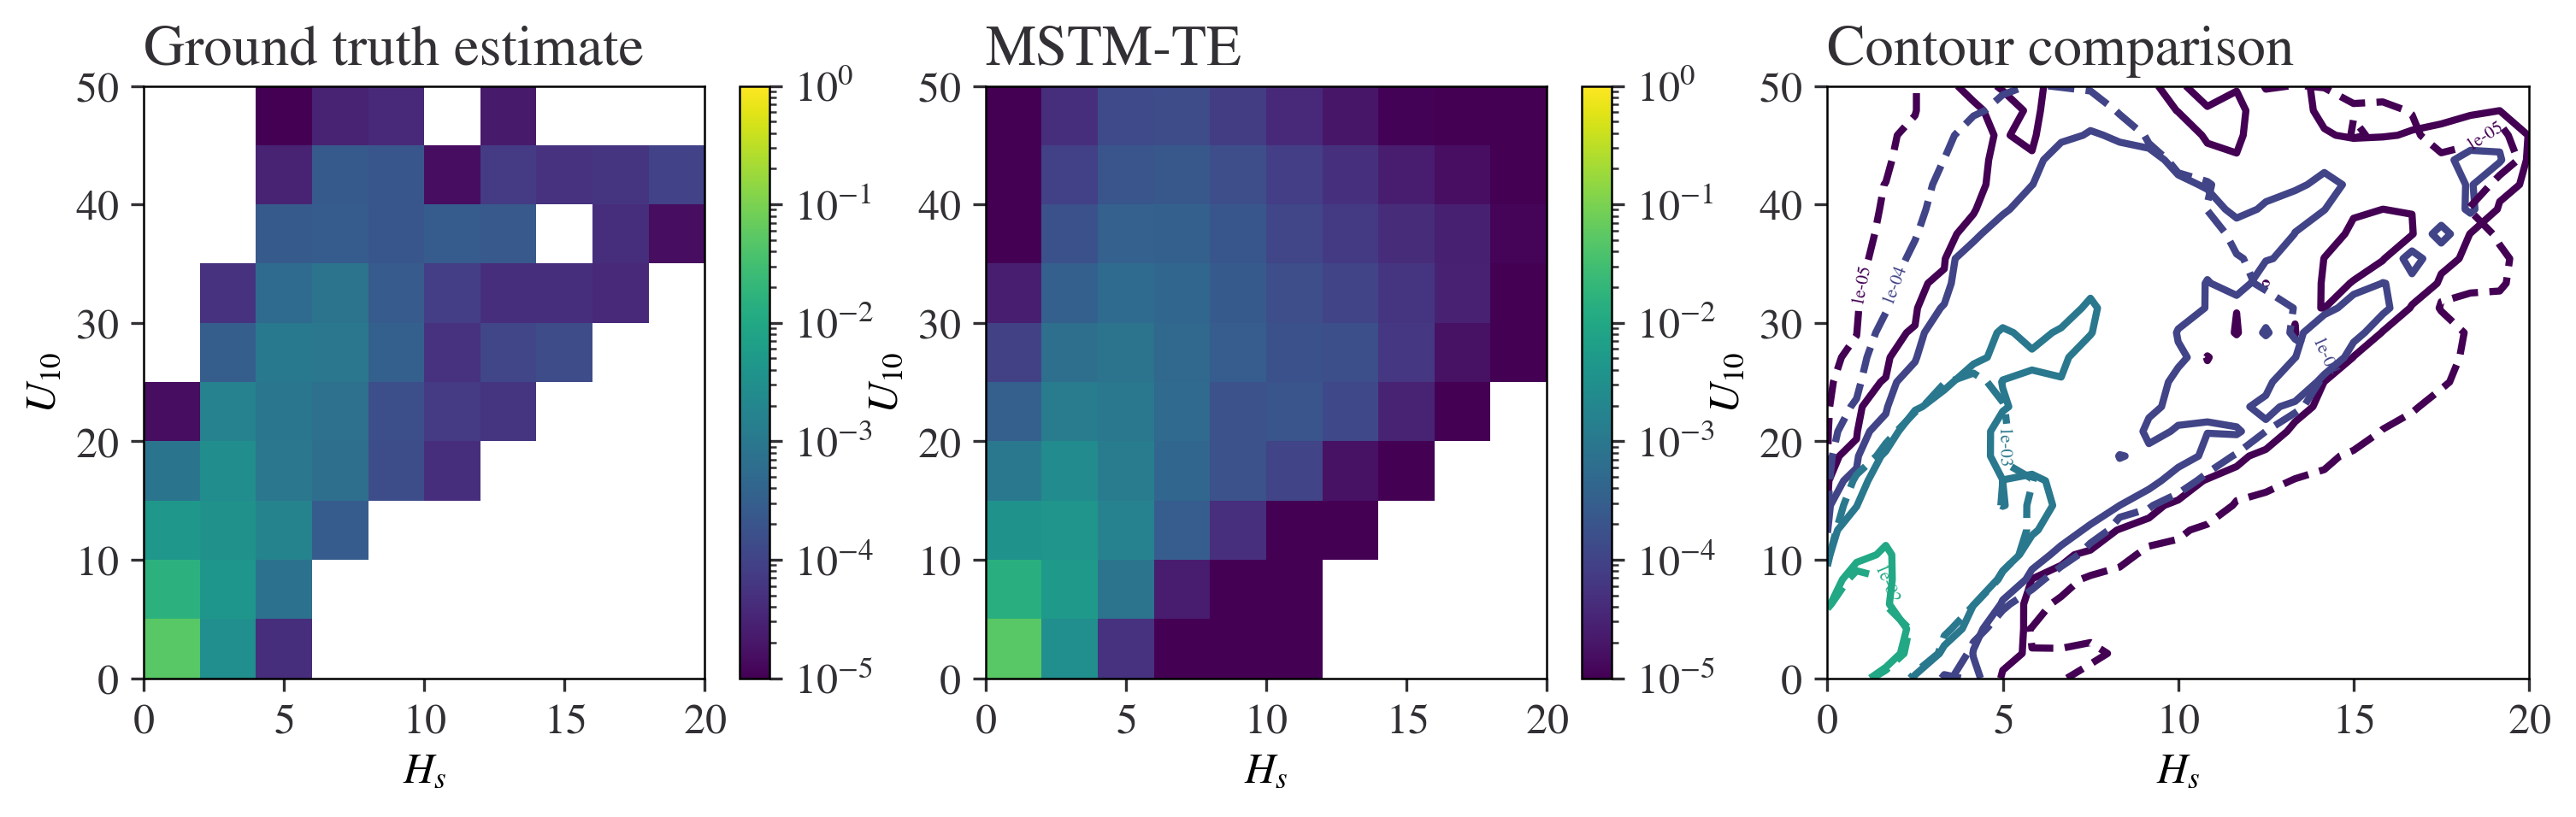

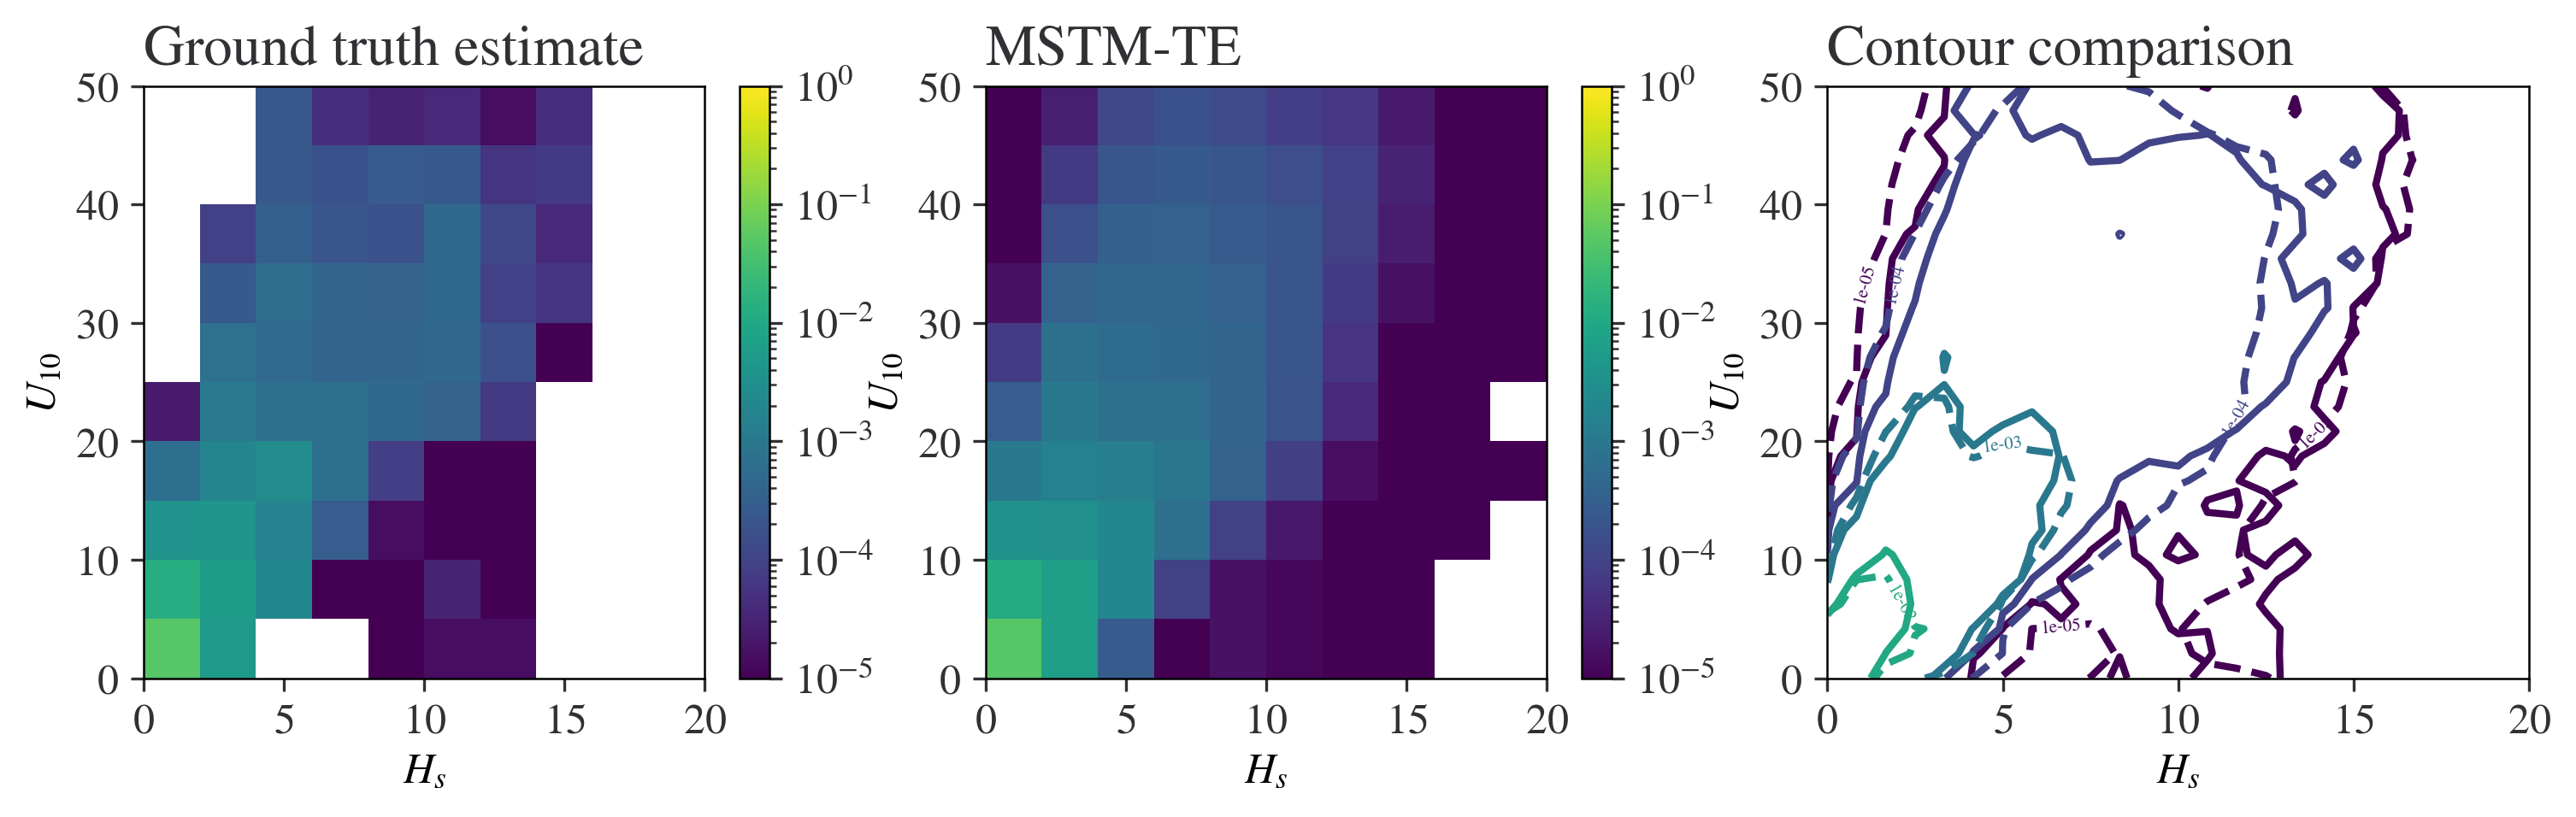

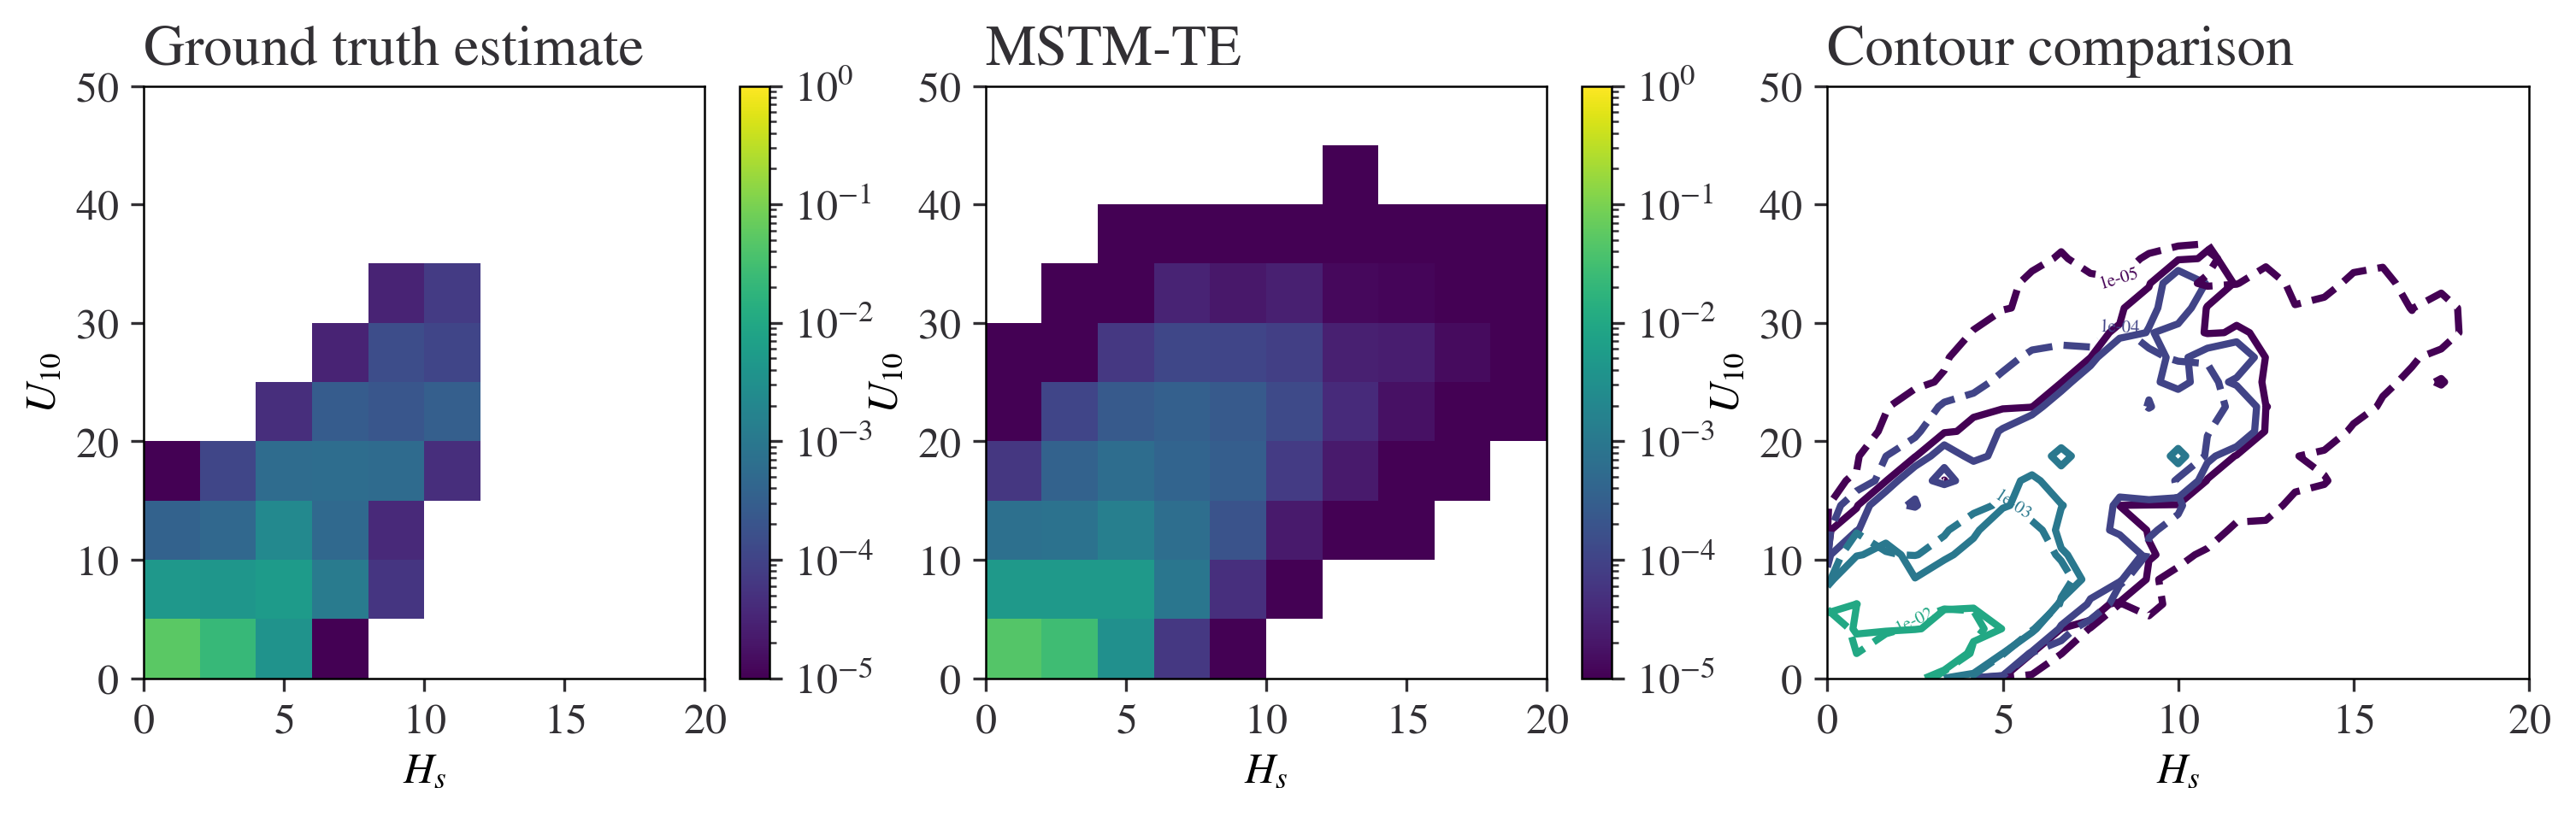

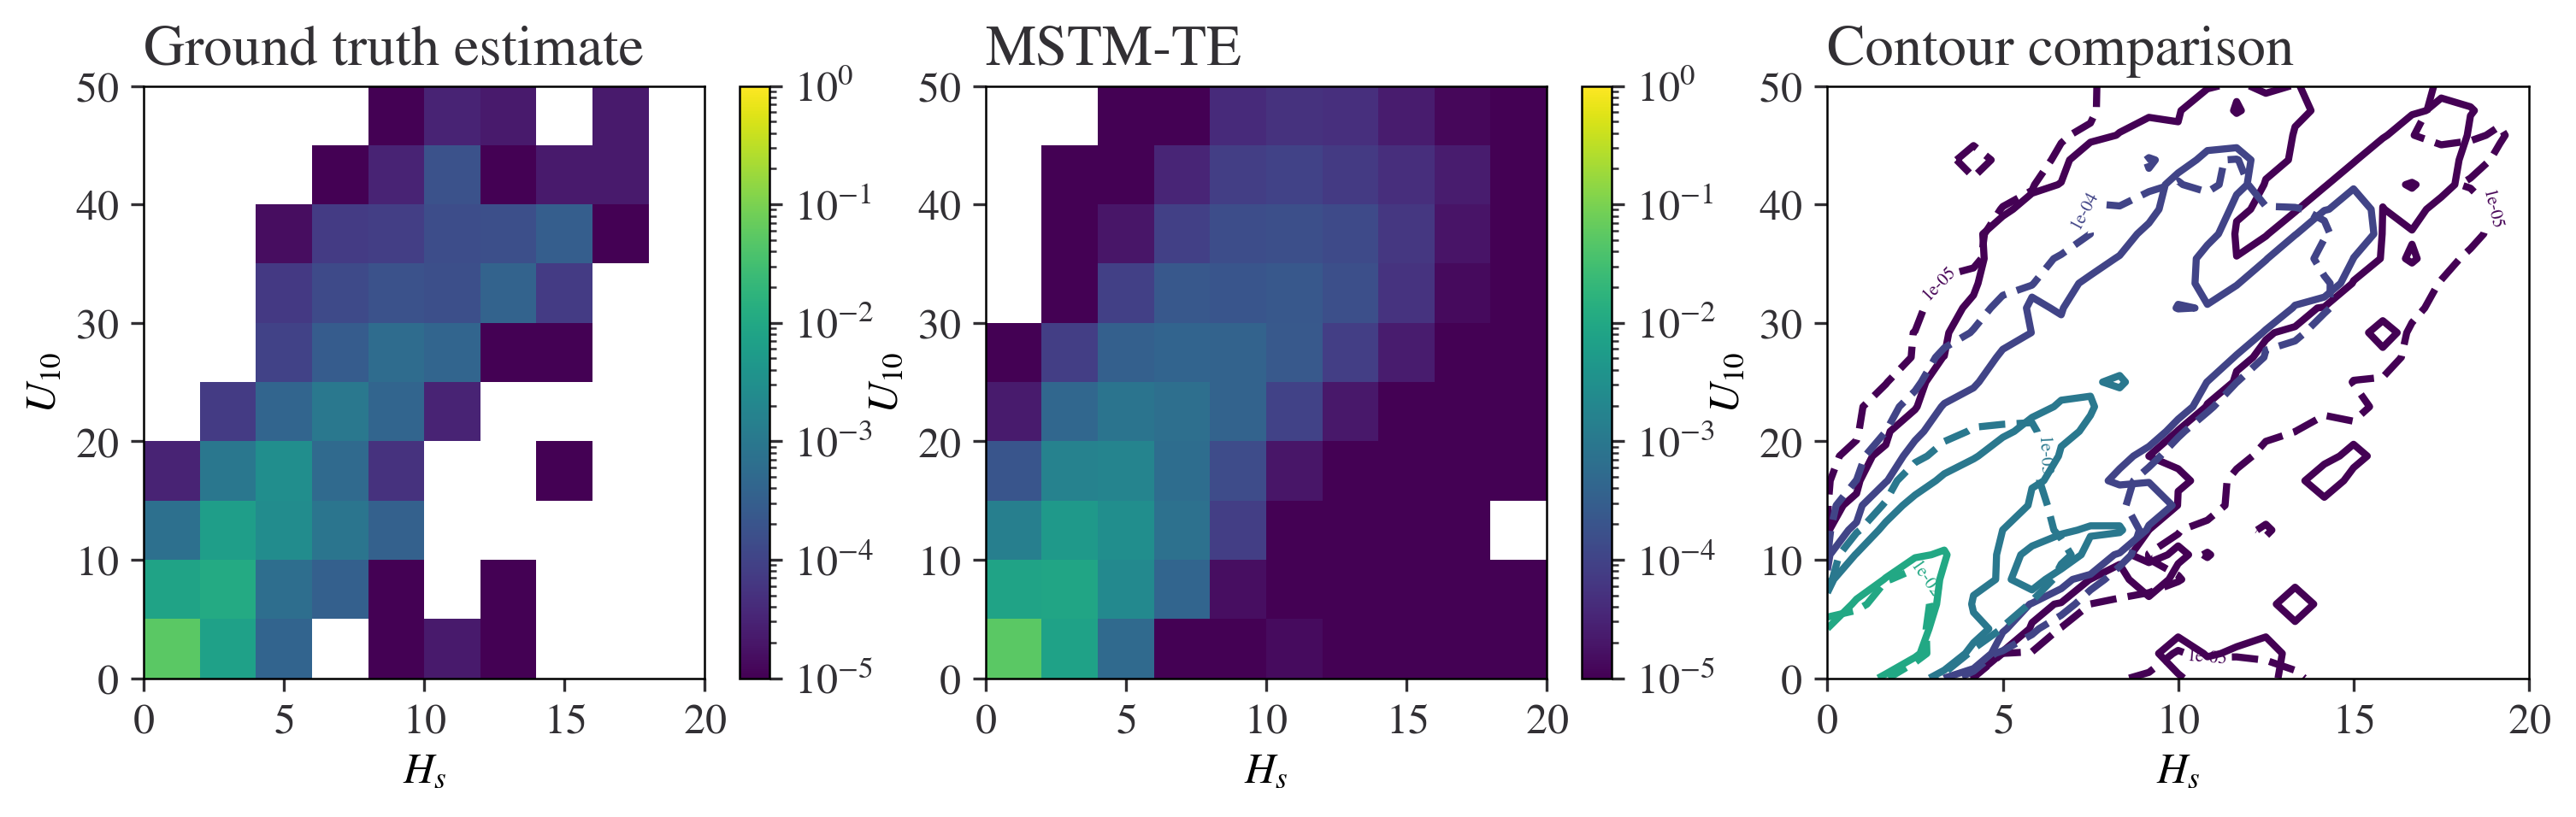

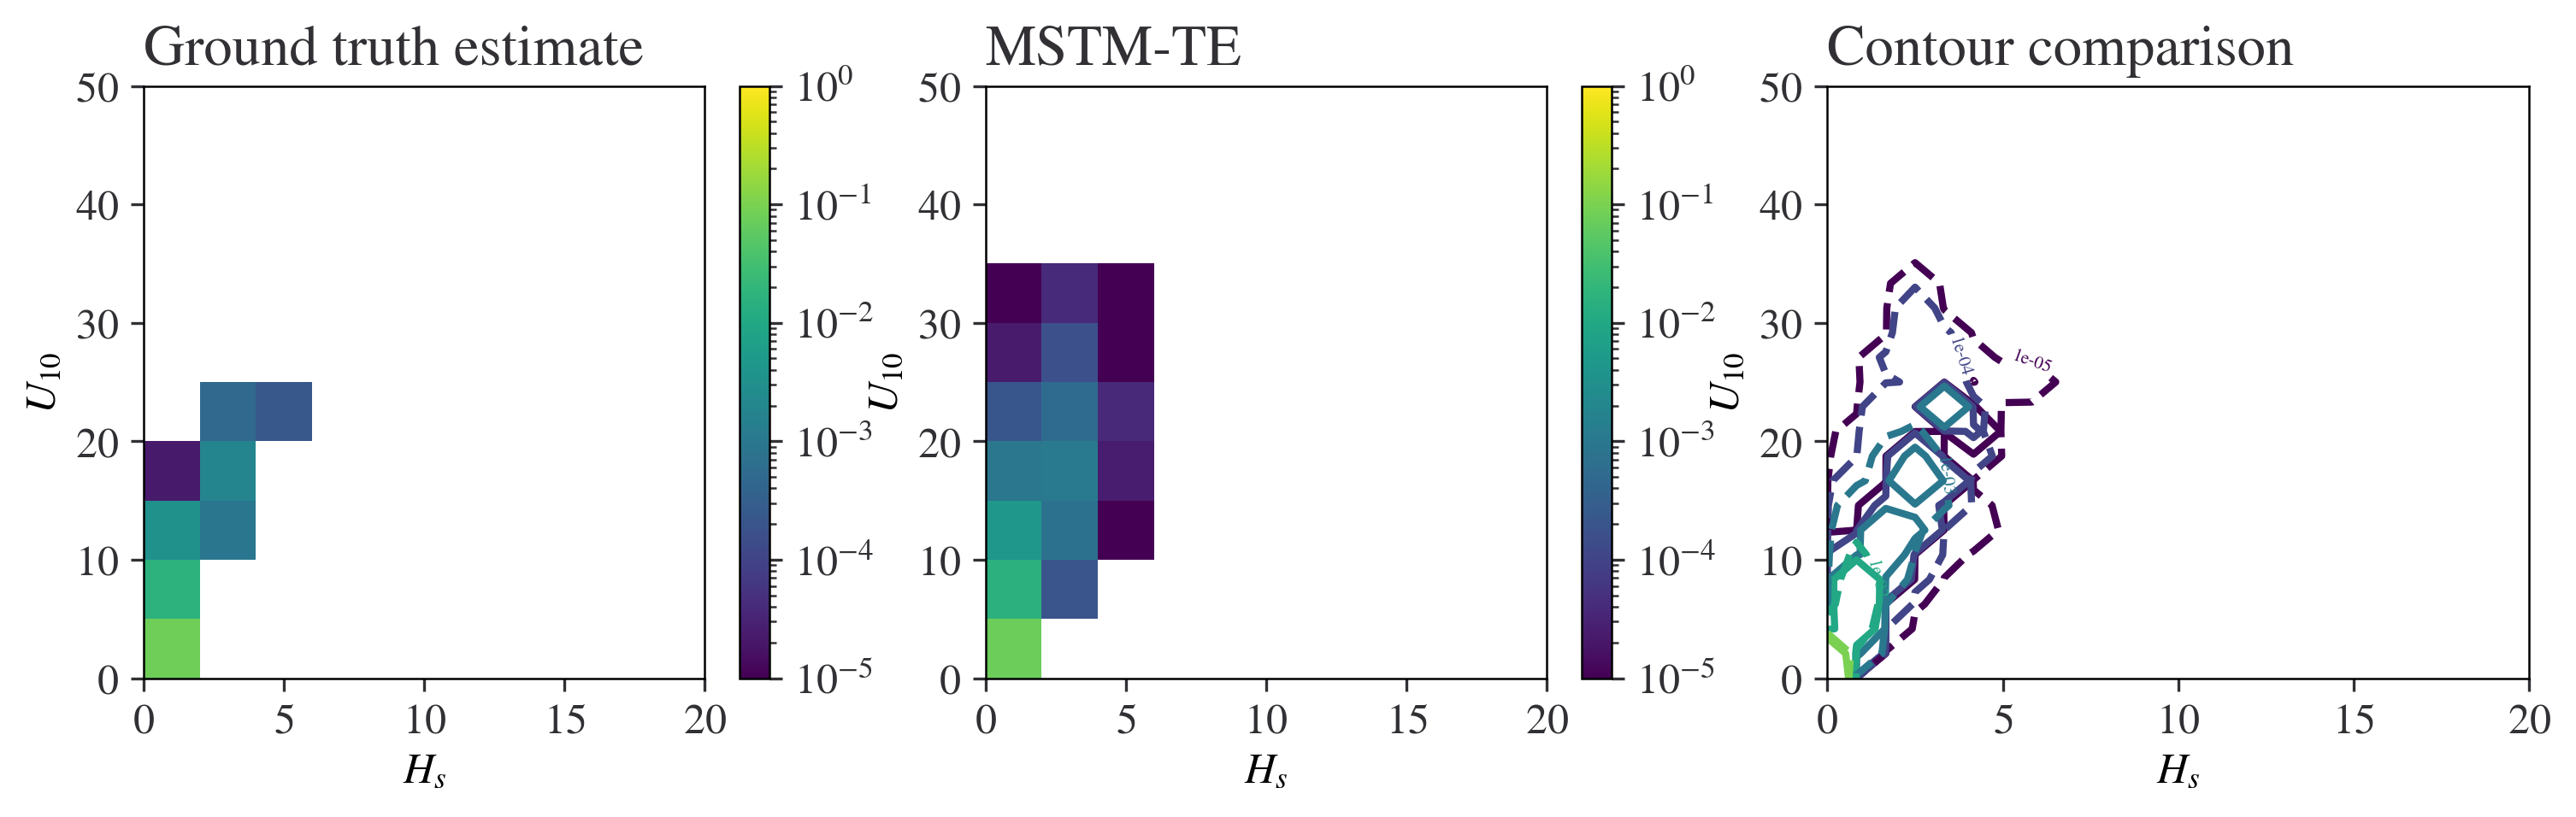

In [ ]:
for loc_i in range(0,5):
  draw_contour_comparison_random_subsample(loc_i)

## Fixed subsample

In [ ]:
def draw_contour_comparison_fixed_subsample(loc_i, ssi, res=25):
    num_events_ext = np.count_nonzero(mstme.is_e_any)
    exp_series_ext = [
        ds_exp_series[idx].isel(node=pos_list_5loc[loc_i])[["hs", "UV_10m"]]
        for idx in np.where(mstme.is_e_any)[0]
    ]
    stm_ext = mstme.stm[:, mstme.is_e_any]
    exp_array, exp_unique = es.quantize_exp(
        exp_series_ext, num_events_ext, res, use_temporal
    )
    exp_array *= es.get_mask(res, {"type": mask_type, "threshold": mask_threshold})
    tdata = []
    for i in range(100 * num_events_ext):
        _stm = rng.choice(stm_MSTME_ss[ssi, :, :], size=1, axis=1)
        _idx = rng.choice(num_events_ext)
        _exp_traj = exp_series_ext[_idx].to_array().values
        _tdata = _stm * _exp_traj
        tdata.append(_tdata)
    fig, axes = plt.subplots(1, 3, figsize=(4 * 3, 3), facecolor="white")

    bounds = [[0, 20], [0, 50]]
    axes[0].set_xlabel(STM.H.name())
    axes[0].set_ylabel(STM.U.name())
    axes[0].set_title("Ground truth estimate")
    x_original = []
    y_original = []
    for ei in range(num_events_ext):
        x_original.extend(exp_series_ext[ei]["hs"].values.tolist() * stm_ext[0, ei].values)
        y_original.extend(exp_series_ext[ei]["UV_10m"].values.tolist() * stm_ext[1, ei].values)
    h, xedges, yedges, image = axes[0].hist2d(
        x_original,
        y_original,
        density=True,
        range=bounds,
        # cmax=1e2
        norm=colors.LogNorm(1e-5, 1e0),
    )
    plt.colorbar(image, ax=axes[0])

    axes[1].set_xlabel(STM.H.name())
    axes[1].set_ylabel(STM.U.name())
    axes[1].set_xlim(0, 25)
    axes[1].set_ylim(0, 60)
    axes[1].set_title("MSTM-TE")
    x_TE = []
    y_TE = []
    for td in tdata:
        x_TE.extend(td[0])
        y_TE.extend(td[1])
    h, xedges, yedges, image = axes[1].hist2d(
        x_TE,
        y_TE,
        density=True,
        range=bounds,
        # cmax=1e2
        norm=colors.LogNorm(1e-5, 1e0),
    )
    plt.colorbar(image, ax=axes[1])


    axes[2].set_xlabel(STM.H.name())
    axes[2].set_ylabel(STM.U.name())
    axes[2].set_title("Contour comparison")
    nbins = res
    xi, yi = np.mgrid[0 : 20 : nbins * 1j, 0 : 50 : nbins * 1j]
    levels = [10**i for i in np.arange(-5, 0, 1.0)]

    kde1 = gaussian_kde(np.array([x_original, y_original]))
    zi = kde1(np.vstack([xi.flatten(), yi.flatten()]))
    im1 = axes[2].contour(
        xi,
        yi,
        zi.reshape(xi.shape),
        norm=colors.LogNorm(1e-5, 1e0),
        levels=levels,
        # colors='black',
    )

    kde2 = gaussian_kde(np.array([x_TE, y_TE]))
    zi = kde2(np.vstack([xi.flatten(), yi.flatten()]))
    im2 = axes[2].contour(
        xi,
        yi,
        zi.reshape(xi.shape),
        norm=colors.LogNorm(1e-5, 1e0),
        levels=levels,
        linestyles="--",
        # colors='red',
    )
    axes[2].clabel(im2, inline=True, fontsize=5, fmt="%1.0e")

    plt.savefig(path_out / f"MSTM-TE_comparison_{loc_i}_kde_ssi{ssi}.png", bbox_inches="tight")
    plt.savefig(path_out / f"MSTM-TE_comparison_{loc_i}_kde_ssi{ssi}.pdf", bbox_inches="tight")

C:\Users\Kosuke\AppData\Local\Temp\ipykernel_26708\892767561.py:70: UserWarning: Log scale: values of z <= 0 have been masked
  im1 = axes[2].contour(
C:\Users\Kosuke\AppData\Local\Temp\ipykernel_26708\892767561.py:81: UserWarning: Log scale: values of z <= 0 have been masked
  im2 = axes[2].contour(
C:\Users\Kosuke\AppData\Local\Temp\ipykernel_26708\892767561.py:70: UserWarning: Log scale: values of z <= 0 have been masked
  im1 = axes[2].contour(
C:\Users\Kosuke\AppData\Local\Temp\ipykernel_26708\892767561.py:81: UserWarning: Log scale: values of z <= 0 have been masked
  im2 = axes[2].contour(
C:\Users\Kosuke\AppData\Local\Temp\ipykernel_26708\892767561.py:70: UserWarning: Log scale: values of z <= 0 have been masked
  im1 = axes[2].contour(
C:\Users\Kosuke\AppData\Local\Temp\ipykernel_26708\892767561.py:81: UserWarning: Log scale: values of z <= 0 have been masked
  im2 = axes[2].contour(
C:\Users\Kosuke\AppData\Local\Temp\ipykernel_26708\892767561.py:70: UserWarning: Log scale: va

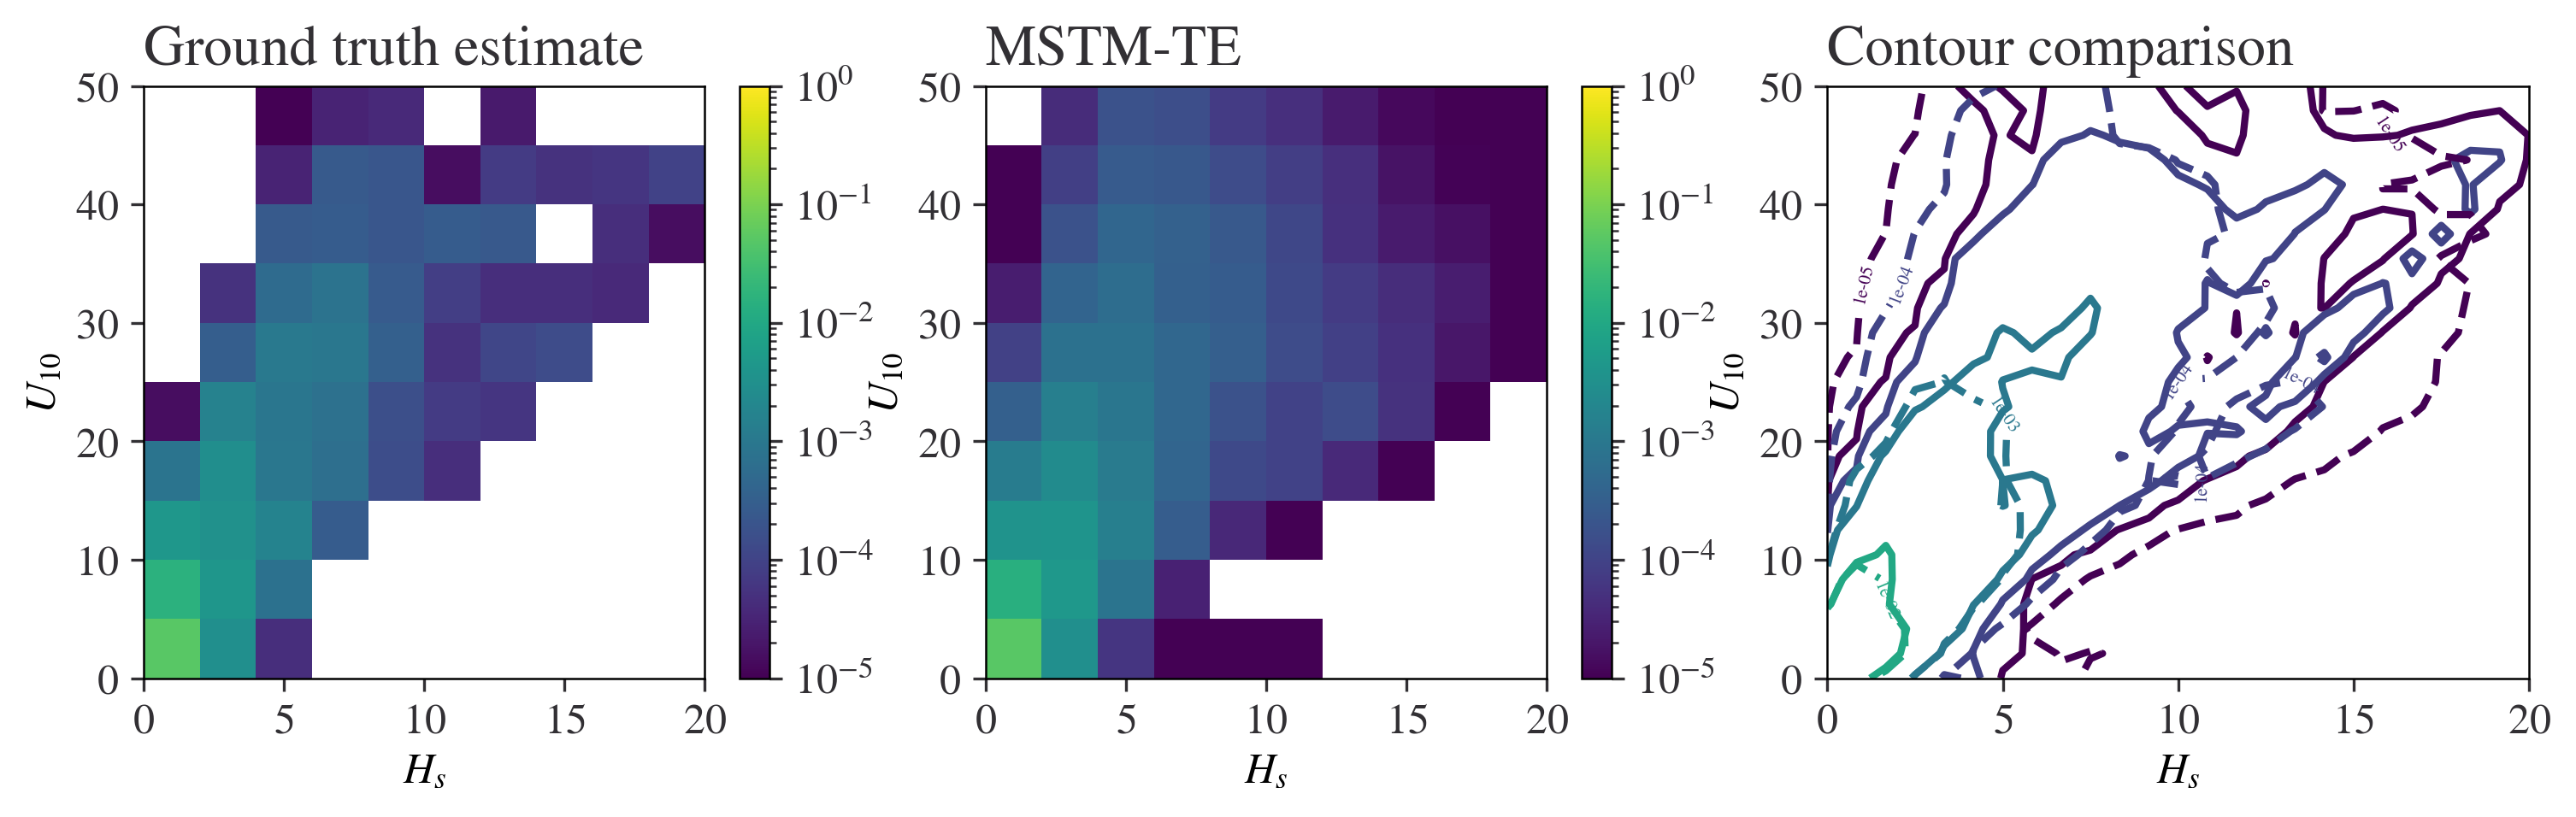

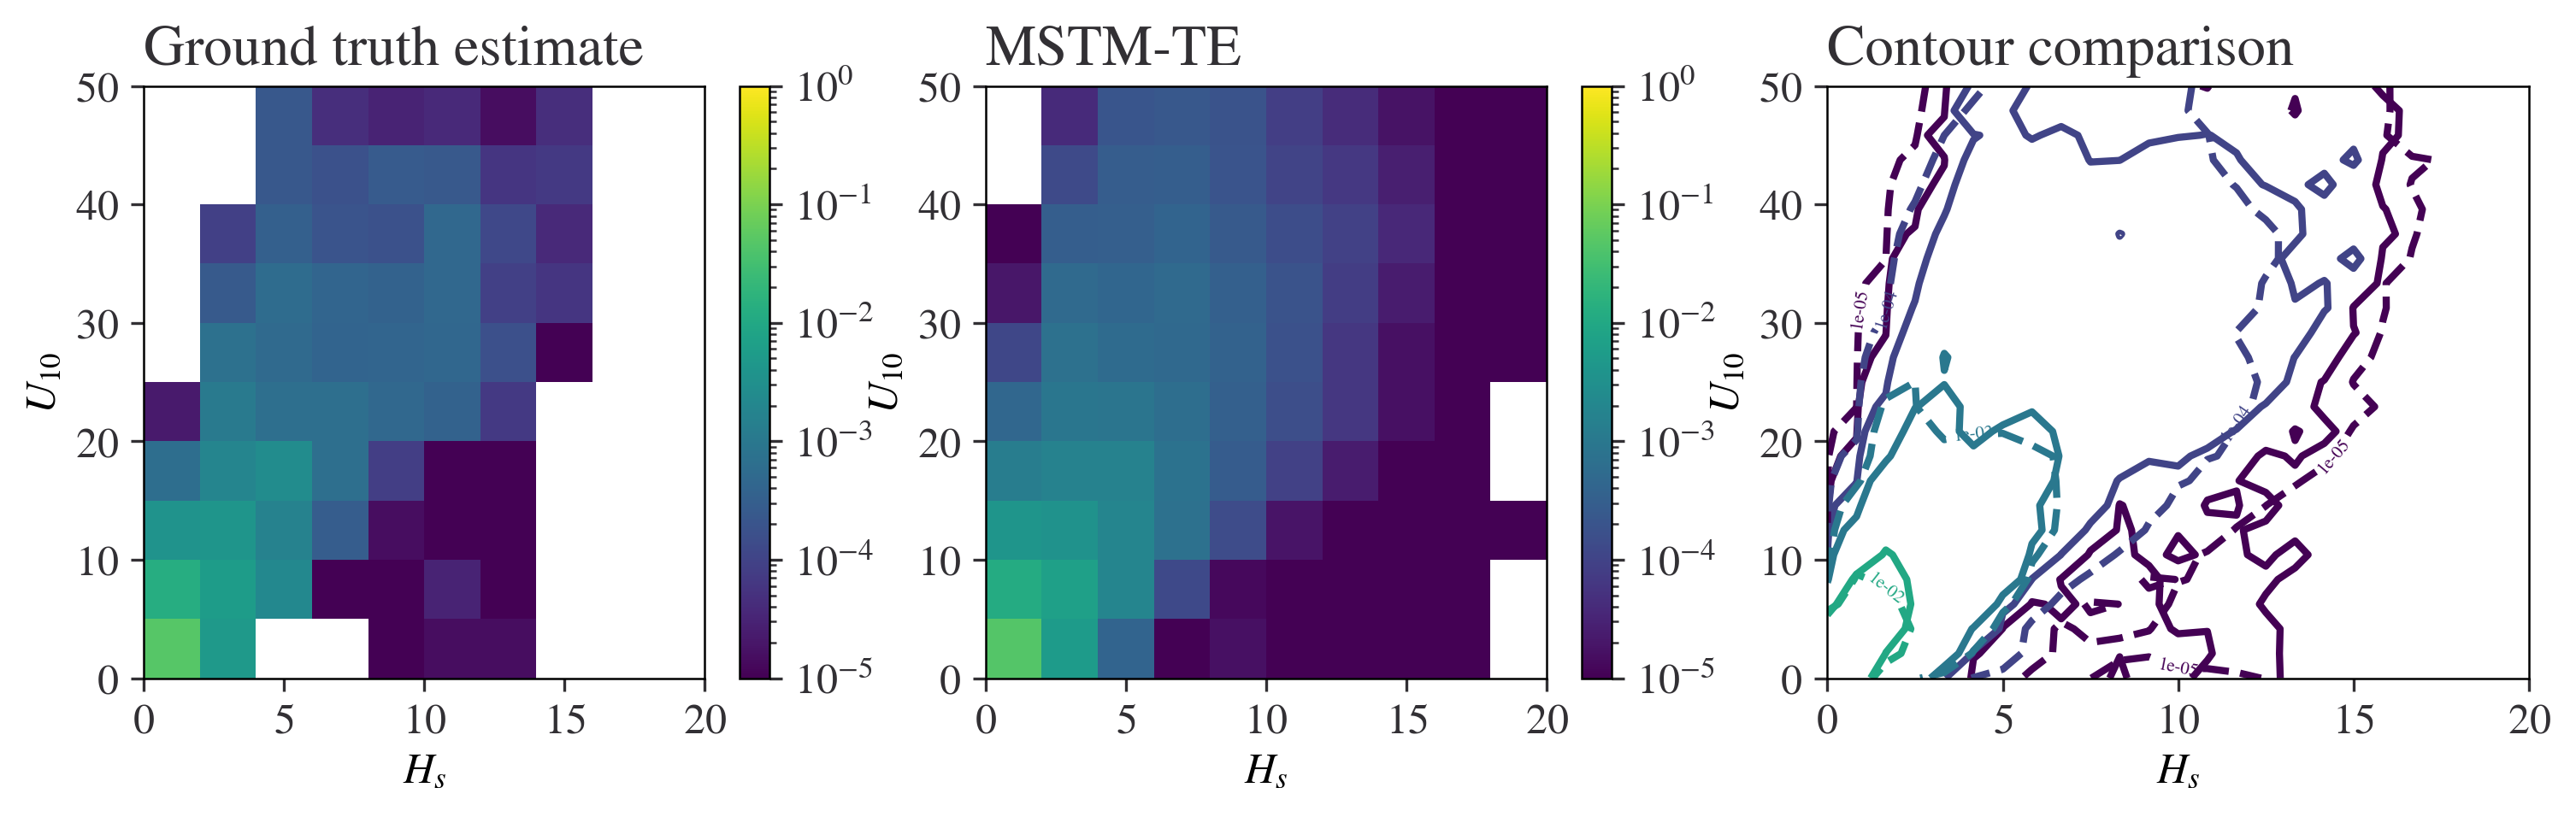

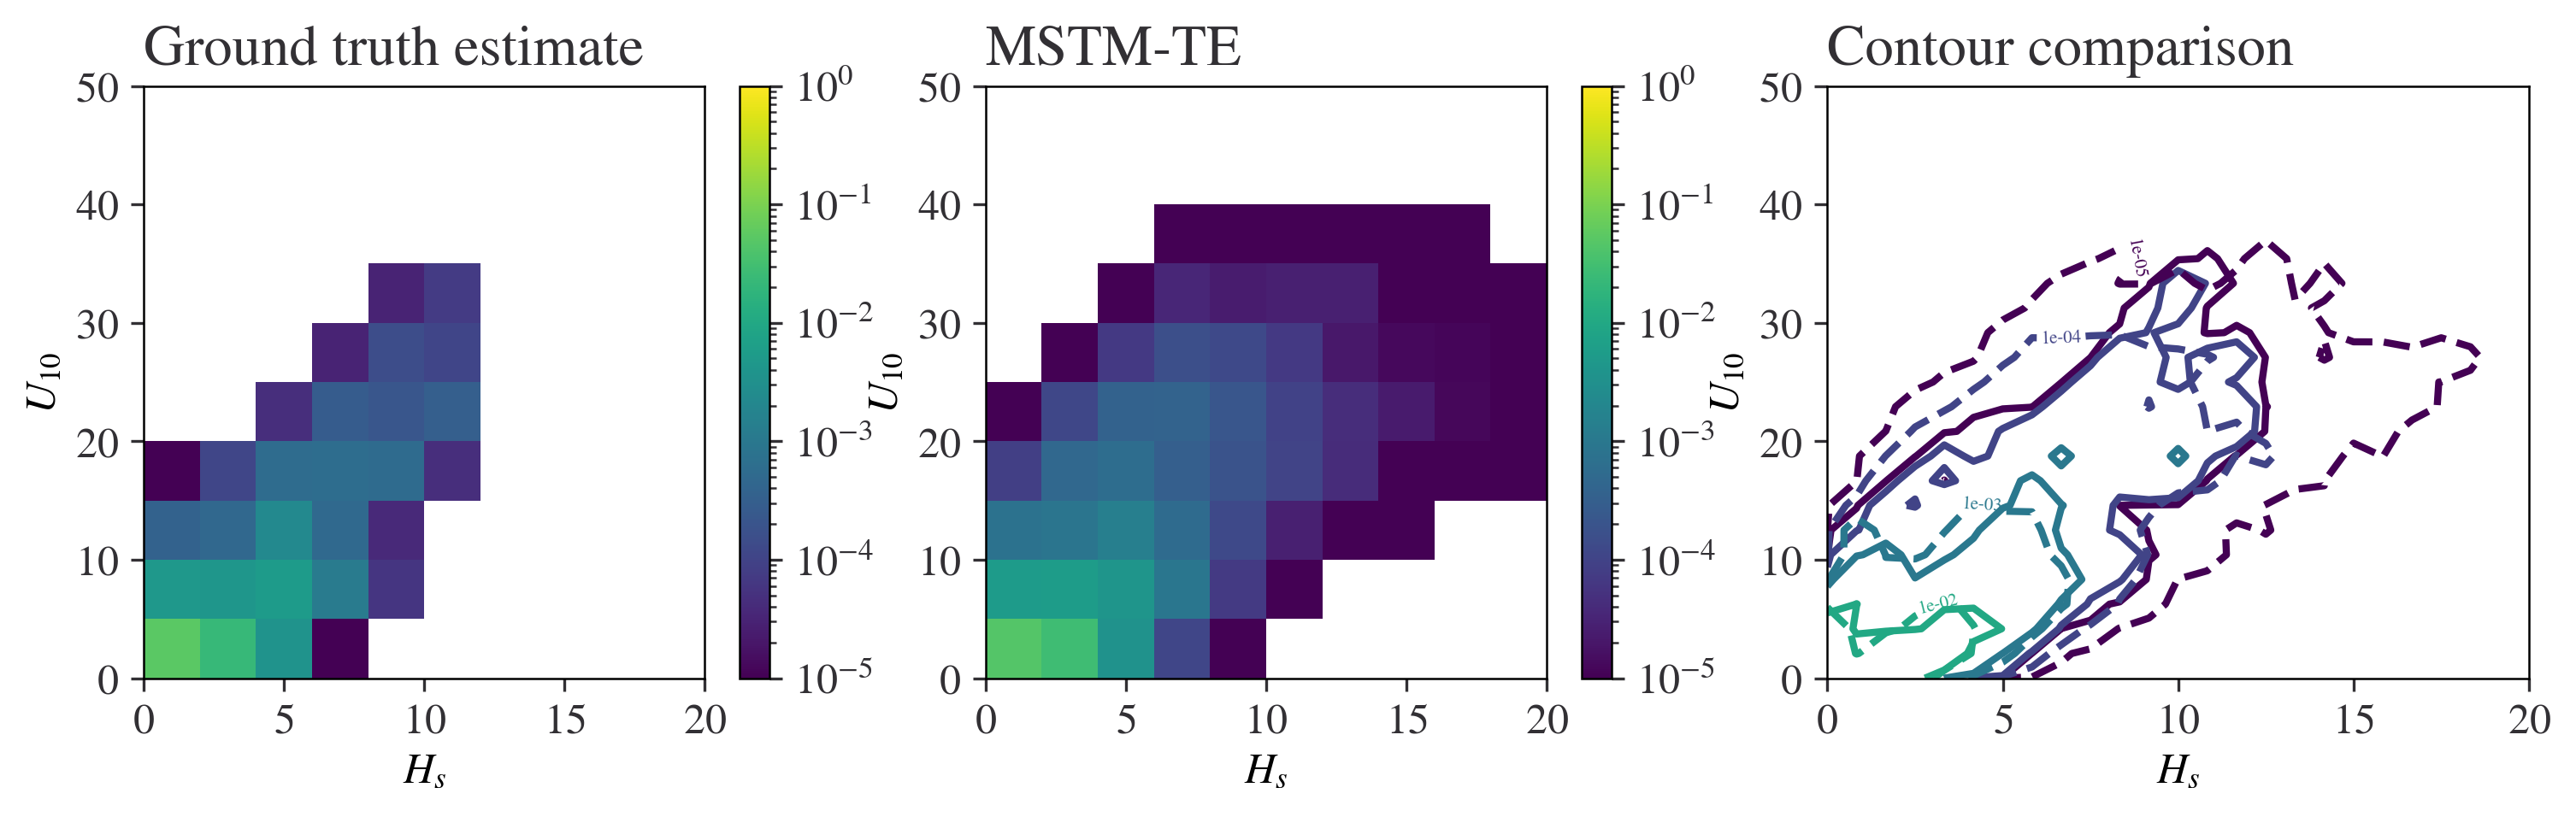

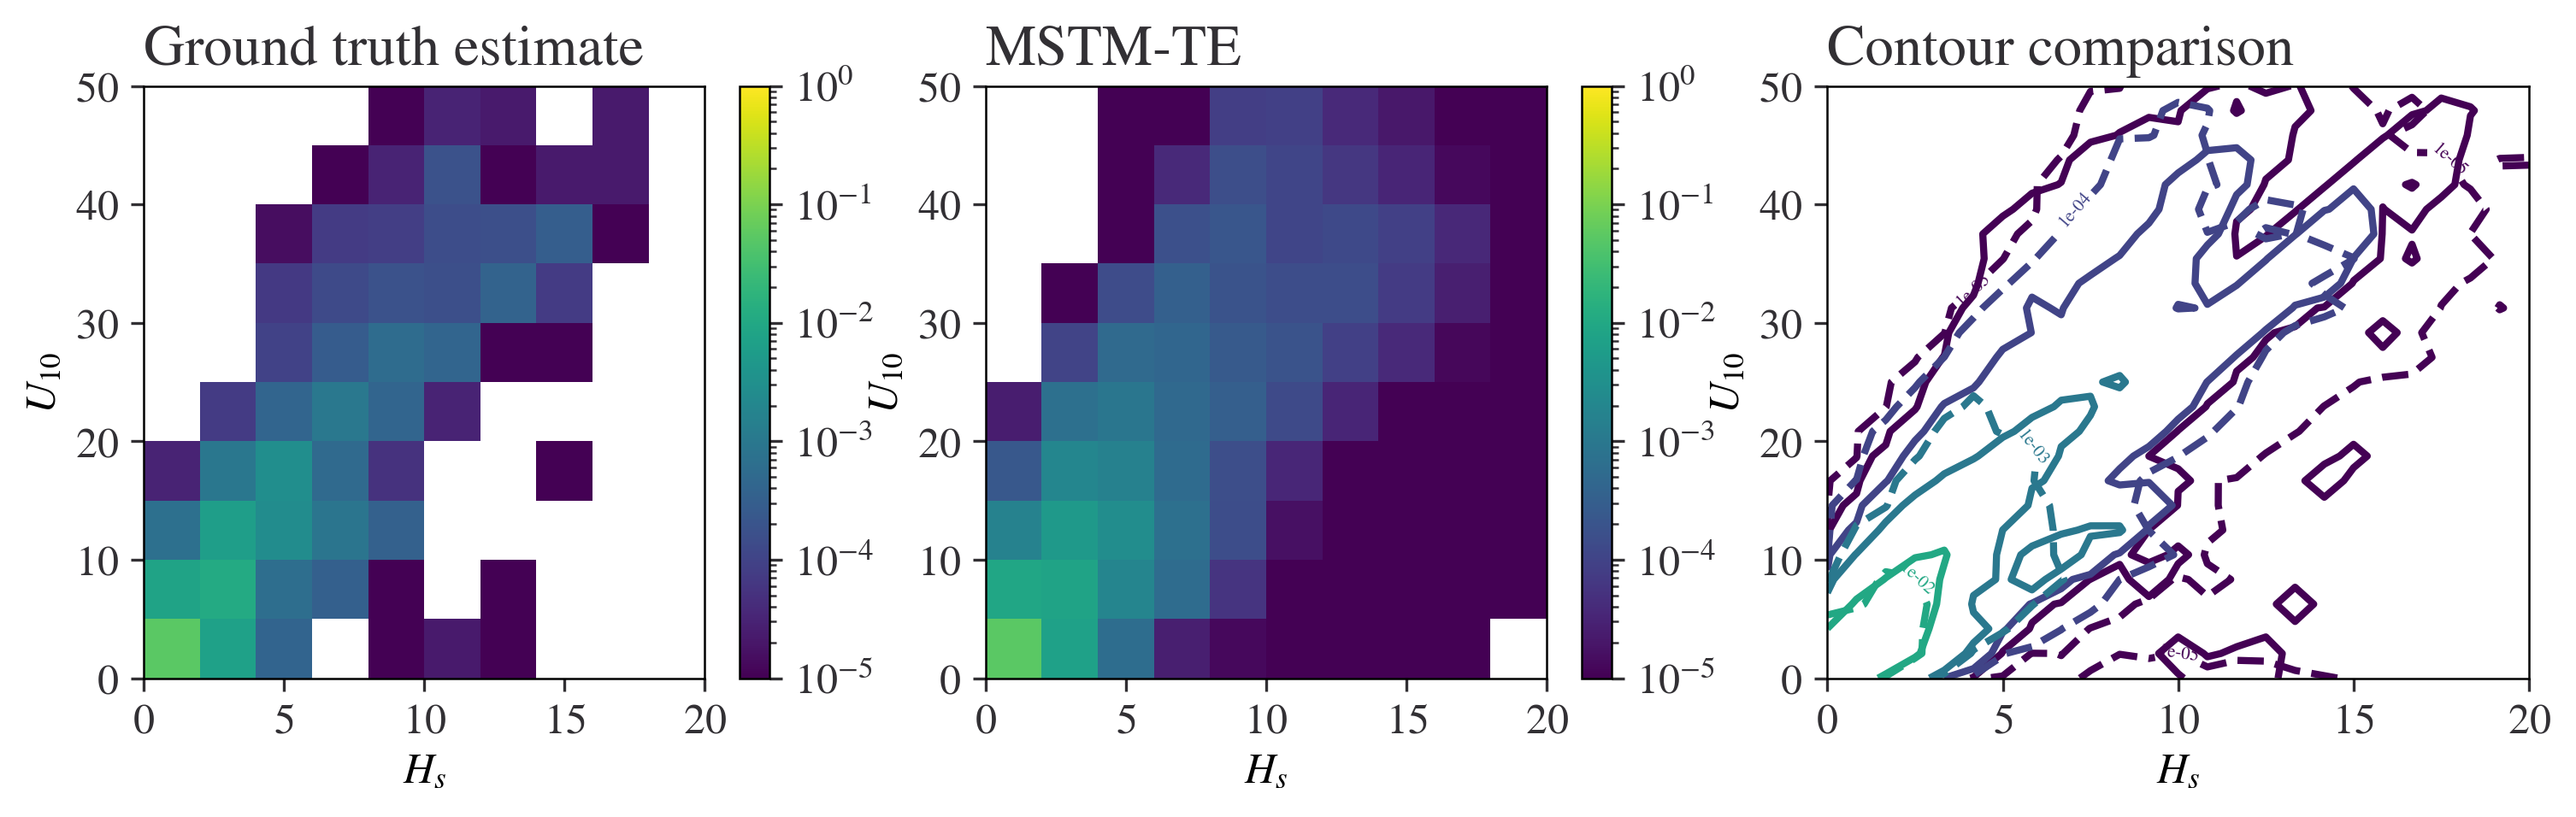

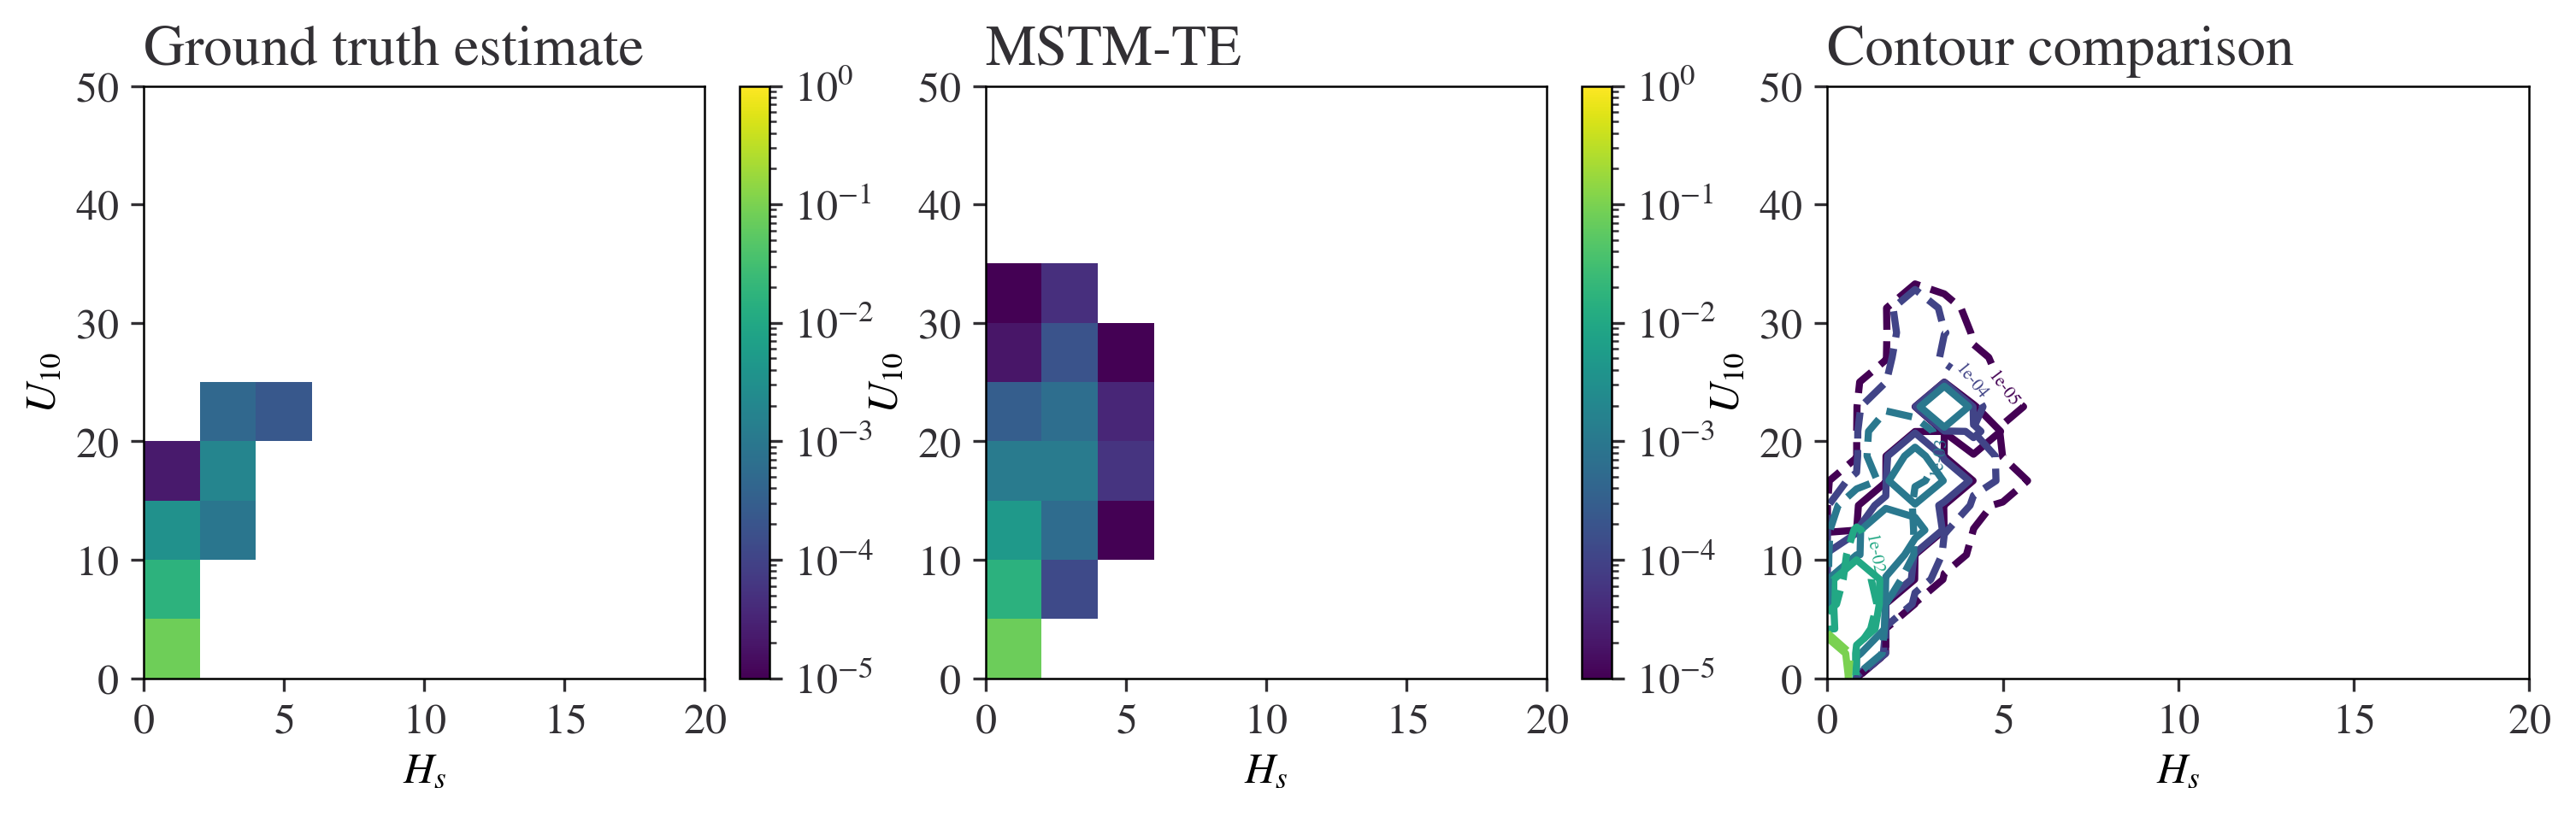

In [ ]:
for ssi in [100]:
# for ssi in [100,200,300,400,500]:
  for loc_i in range(0,5):
    draw_contour_comparison_fixed_subsample(loc_i,ssi)

## Uncertainty

C:\Users\Kosuke\AppData\Local\Temp\ipykernel_22628\2628676974.py:60: UserWarning: No contour levels were found within the data range.
  im1 = axes[2].contour(
C:\Users\Kosuke\AppData\Local\Temp\ipykernel_22628\2628676974.py:86: UserWarning: No contour levels were found within the data range.
  im2 = axes[2].contour(


KeyboardInterrupt: 

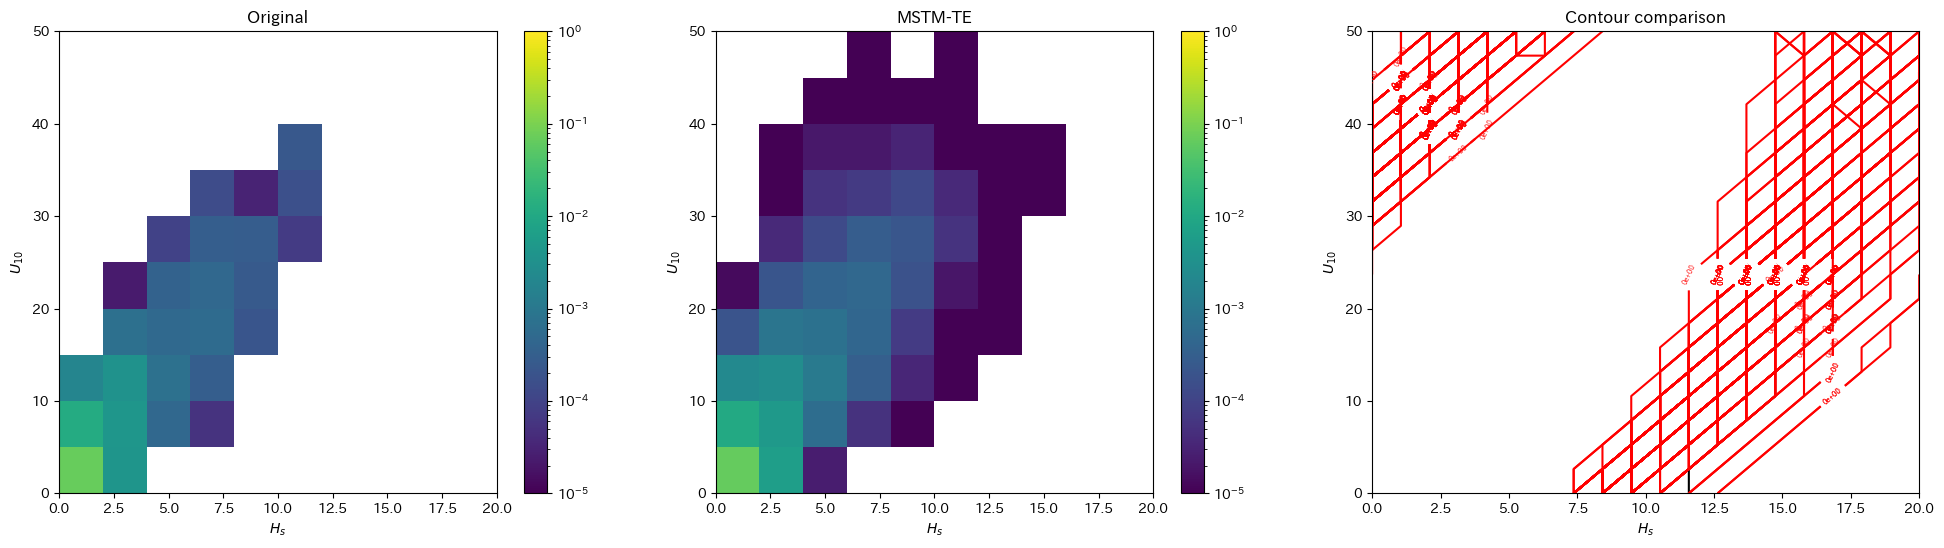

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(8 * 3, 6), facecolor="white")

bounds = [[0, 20], [0, 50]]
axes[0].set_xlabel(STM.H.name())
axes[0].set_ylabel(STM.U.name())
axes[0].set_title("Ground truth estimate")
x = []
y = []
for ei in range(num_events_ext):
    x.extend(exp_series_ext[ei]["hs"].values.tolist() * stm_ext[0, ei].values)
    y.extend(exp_series_ext[ei]["UV_10m"].values.tolist() * stm_ext[1, ei].values)
h, xedges, yedges, image = axes[0].hist2d(
    x,
    y,
    density=True,
    range=bounds,
    # cmax=1e2
    norm=colors.LogNorm(1e-5, 1e0),
)
plt.colorbar(image, ax=axes[0])


axes[1].set_xlabel(STM.H.name())
axes[1].set_ylabel(STM.U.name())
axes[1].set_xlim(0, 25)
axes[1].set_ylim(0, 60)
axes[1].set_title("MSTM-TE")
x = []
y = []
for td in tdata:
    x.extend(td[0])
    y.extend(td[1])
h, xedges, yedges, image = axes[1].hist2d(
    x,
    y,
    density=True,
    range=bounds,
    # cmax=1e2
    norm=colors.LogNorm(1e-5, 1e0),
)
plt.colorbar(image, ax=axes[1])


#########
axes[2].set_xlabel(STM.H.name())
axes[2].set_ylabel(STM.U.name())
axes[2].set_title("Contour comparison")

x = []
y = []
for ei in range(num_events_ext):
    x.extend(exp_series_ext[ei]["hs"].values.tolist() * stm_ext[0, ei].values)
    y.extend(exp_series_ext[ei]["UV_10m"].values.tolist() * stm_ext[1, ei].values)
nbins = 20
kde1 = gaussian_kde(np.array([x, y]))
xi, yi = np.mgrid[0 : 20 : nbins * 1j, 0 : 50 : nbins * 1j]
zi = kde1(np.vstack([xi.flatten(), yi.flatten()]))

levels = [10**i for i in []]
im1 = axes[2].contour(
    xi,
    yi,
    zi.reshape(xi.shape),
    # norm=colors.LogNorm(1e-5, 1e0),
    levels=levels,
    colors="black",
)
axes[2].clabel(im1, inline=True, fontsize=5, fmt="%1.0e")

for ssi in range(1000):
    tdata = []
    for i in range(100 * num_events_ext):
        _stm = rng.choice(stm_MSTME_ss[ssi, :, :], size=1, axis=1)
        _idx = rng.choice(num_events_ext)
        _exp_traj = exp_series_ext[_idx].to_array().values
        _tdata = _stm * _exp_traj
        tdata.append(_tdata)

    x = []
    y = []
    for td in tdata:
        x.extend(td[0])
        y.extend(td[1])
    kde2 = gaussian_kde(np.array([x, y]))
    zi = kde2(np.vstack([xi.flatten(), yi.flatten()]))
    im2 = axes[2].contour(
        xi,
        yi,
        zi.reshape(xi.shape),
        # norm=colors.LogNorm(1e-5, 1e0),
        levels=levels,
        colors="red",
    )
    axes[2].clabel(im2, inline=True, fontsize=5, fmt="%1.0e")

custom_lines = [Line2D([0], [0], color="k"), Line2D([0], [0], color="r")]

# ax.legend(custom_lines, [f'{thr:.2f}'for thr in thr_com_list])
axes[2].legend(custom_lines, ["Empirical", "MSTM-TE"])

plt.savefig(path_out / f"MSTM-TE_comparison_{loc_i}_kde_variance.png", bbox_inches="tight")
plt.savefig(path_out / f"MSTM-TE_comparison_{loc_i}_kde_variance.pdf", bbox_inches="tight")

## Just exposure

In [ ]:
texp=[]
for i in range(1000):
  _idx = rng.choice(num_events_ext)
  _exp_traj = exp_series_ext[_idx].to_array().values
  texp.append(_exp_traj)

In [ ]:
exp_series_ext[_idx].to_array().values

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.00051177,
        0.00051177, 0.00102354, 0.00102354, 0.00102354, 0.00153531,
        0.00153531, 0.00153531, 0.00153531, 0.00204708, 0.00255885,
        0.00307062, 0.00409417, 0.00562948, 0.00767656, 0.0087001 ,
        0.0087001 , 0.0087001 , 0.00921187, 0.00972364, 0.01074719,
        0.0122825 , 0.01381781, 0.01586489, 0.01842375, 0.02149437,
        0.02507677, 0.0296827 , 0.03531218, 0.04145343, 0.04810645,
        0.05527124, 0.0629478 , 0.07062437, 0.0788127 , 0.08597749,
        0.09314227, 0.09877175, 0.10388946, 0.11156603, 0.12077789,
        0.129478  , 0.13817811, 0.14636643, 0.15

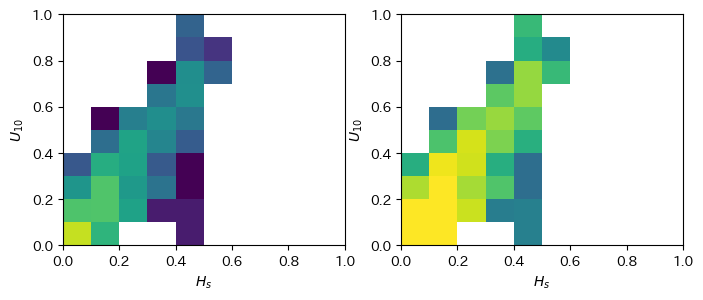

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(4*2, 3), facecolor="white")

bounds=[[0, 1], [0, 1]]
axes[0].set_xlabel(STM.H.name())
axes[0].set_ylabel(STM.U.name())
x = []
y = []
for ei in range(num_events_ext):
    x.extend(exp_series_ext[ei]["hs"].values.tolist())
    y.extend(exp_series_ext[ei]["UV_10m"].values.tolist())
h,xedges,yedges,image = axes[0].hist2d(
    x,
    y,
    range=bounds,
    # cmax=1e2
    norm = colors.LogNorm(1e-0,1e4),
)
# plt.colorbar(image)


axes[1].set_xlabel(STM.H.name())
axes[1].set_ylabel(STM.U.name())
axes[1].set_xlim(0,25)
axes[1].set_ylim(0,60)
x = []
y = []
for td in texp:
    x.extend(td[0])
    y.extend(td[1])
h,xedges,yedges,image = axes[1].hist2d(
    x,
    y,
    range=bounds,
    # cmax=1e2
    norm = colors.LogNorm(1e-0,1e4),
)


# plt.colorbar(image)

# Stuff for explanation

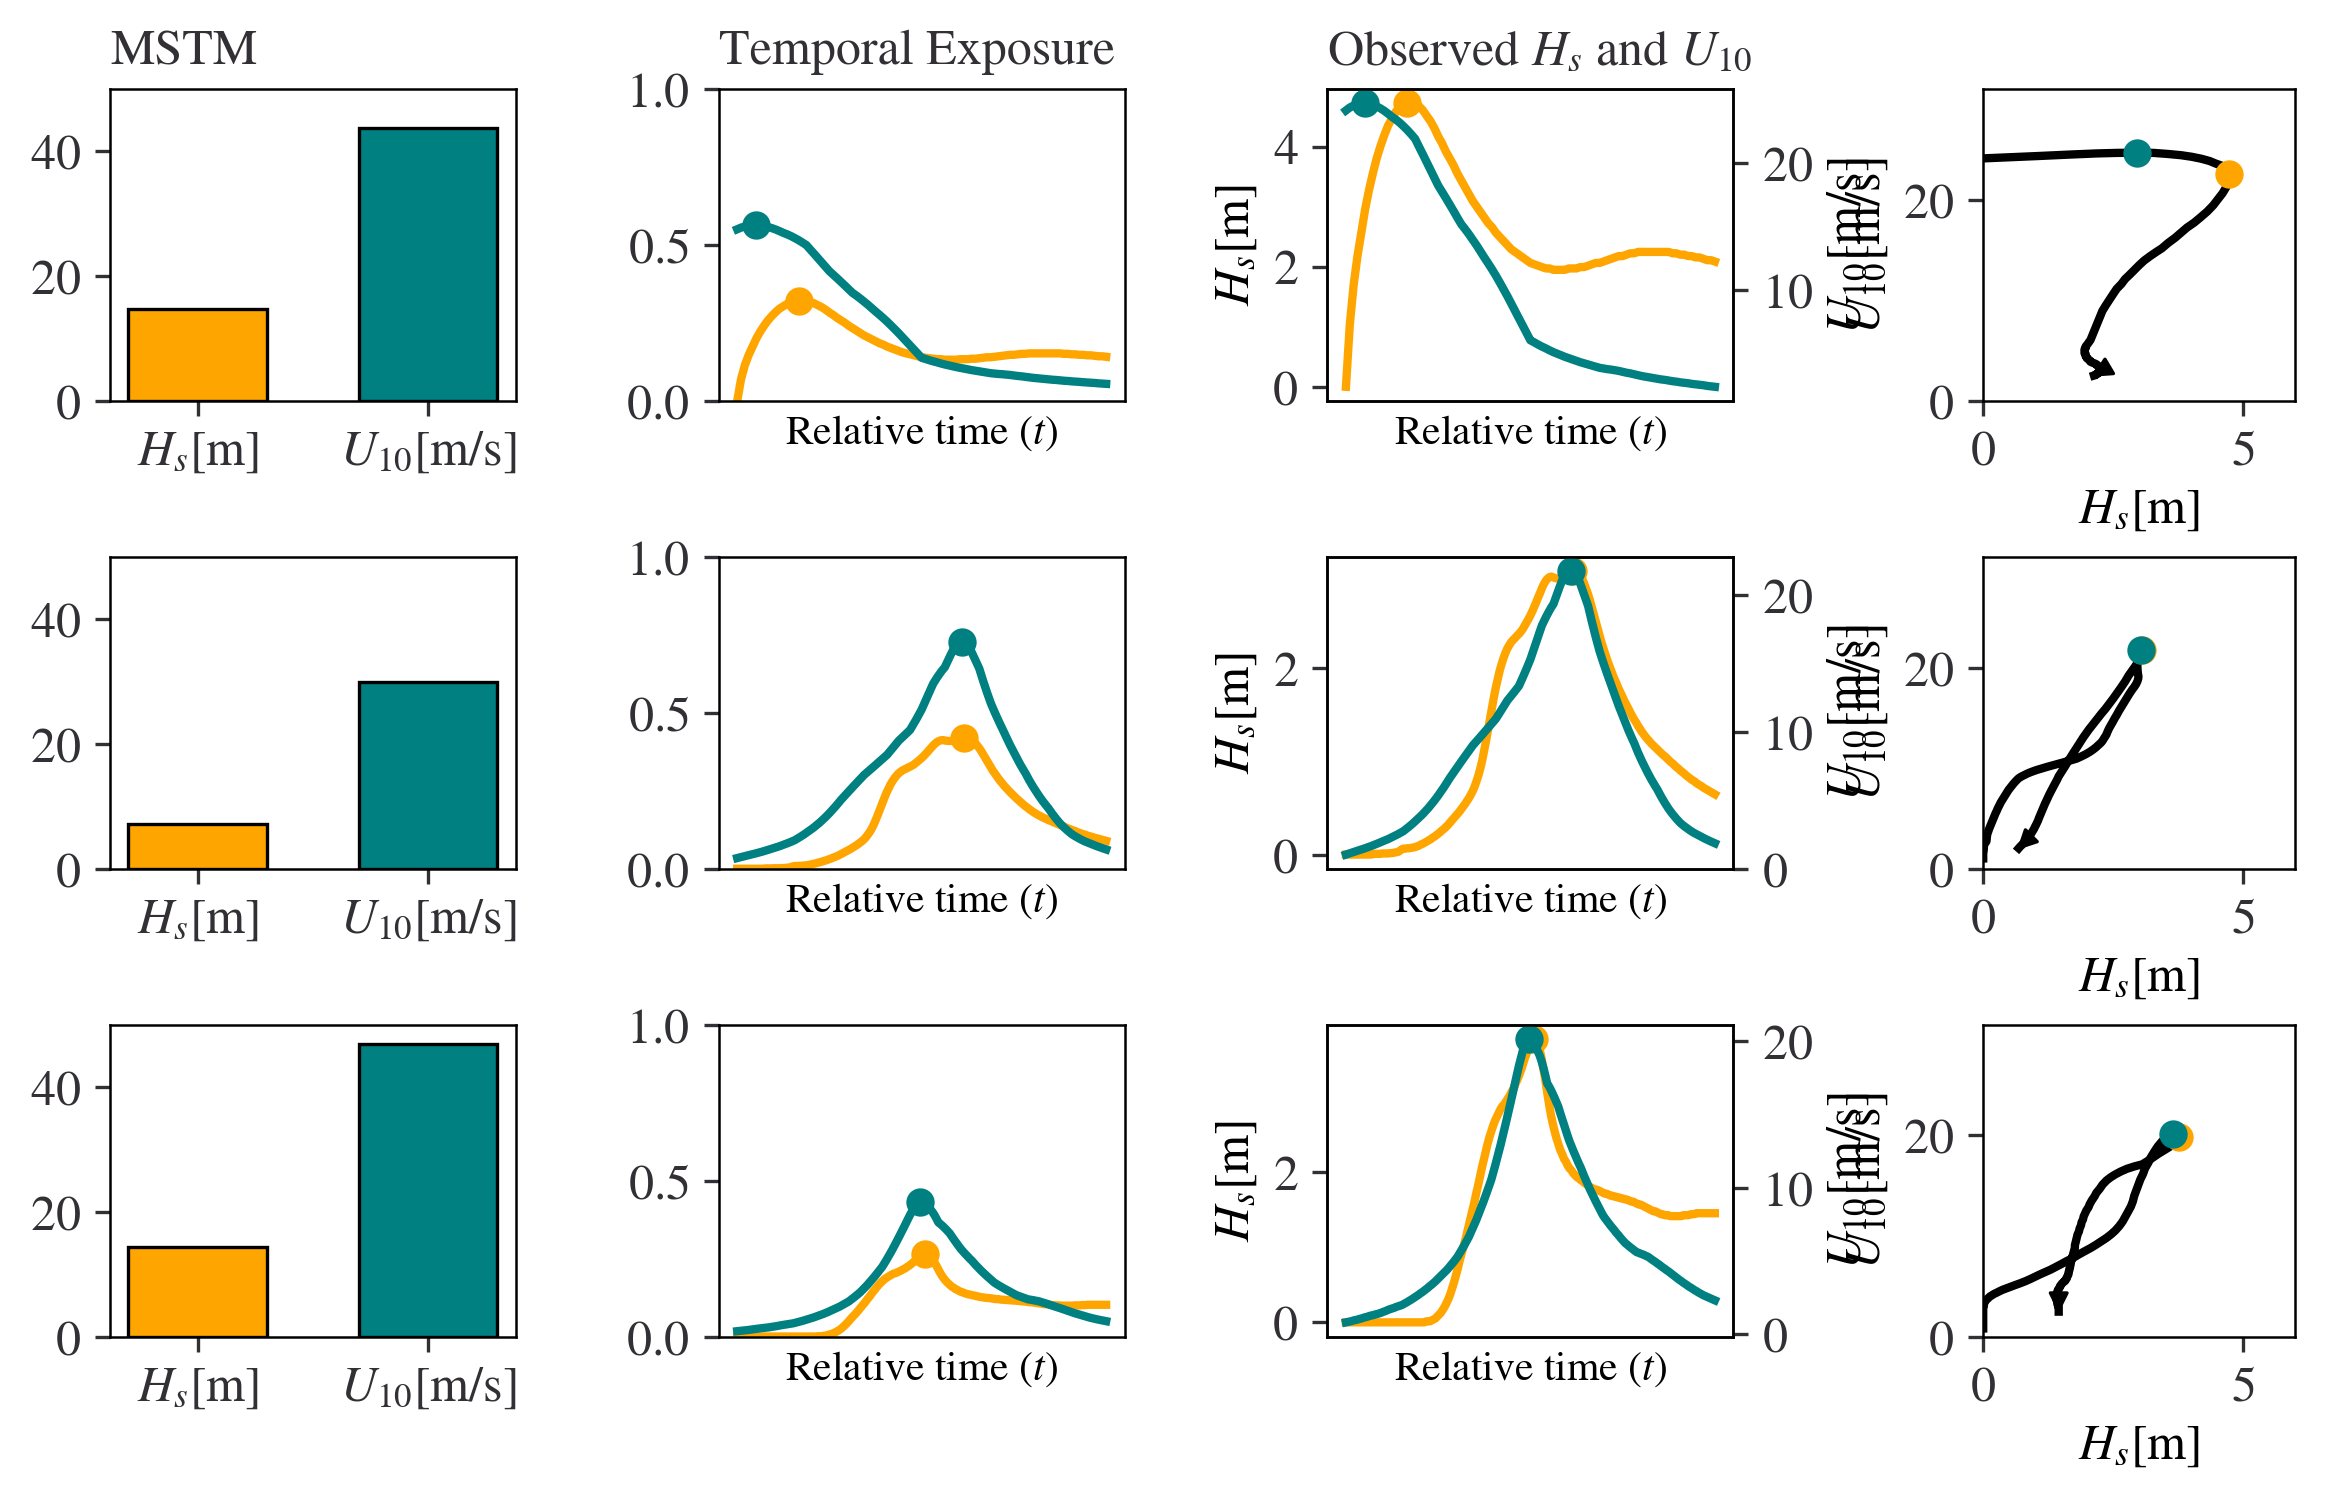

In [ ]:
nni=0

fig, axes = plt.subplots(
    3,
    4,
    figsize=(4 * 4*0.6, 3 * 3*0.6),
)
fig.subplots_adjust(hspace=0.5, wspace=0.5)
mstm_list = mstme_condition.stm.data[:, 0:3].T
title_size=12
axes[0, 0].set_title("MSTM",size=title_size)
axes[0, 1].set_title("Temporal Exposure",size=title_size)
axes[0, 2].set_title("Observed $H_s$ and $U_{10}$",size=title_size)

for i in range(3):
    ds = xr.load_dataset(f"./data/exp_series/{i:03d}.nc")
    ni = 20569 + nni * i
    x = ds["time"]
    yh = ds["hs"].isel(node=ni)
    yu = ds["UV_10m"].isel(node=ni)
    idx_h = yh.argmax()
    idx_u = yu.argmax()
    mstm = mstm_list[i]

    ##
    axes[i, 0].set_ylim(0, 50)
    axes[i, 0].bar(
        [f"{STM.H.name()}[m]", f"{STM.U.name()}[m/s]"],
        height=mstm,
        width=0.6,
        color=["orange", "teal"],
    )

    ##
    axes[i, 1].set_ylim(0, 1)
    axes[i, 1].plot(x, yh, c="orange", label=STM.H.name())
    axes[i, 1].plot(x, yu, c="teal", label=STM.U.name())

    axes[i, 1].scatter(x[idx_h], yh[idx_h], c="orange")
    axes[i, 1].scatter(x[idx_u], yu[idx_u], c="teal")

    # axes[i,1].xaxis.set_major_formatter(
    #     mdates.ConciseDateFormatter(
    #         # axes[i,1].xaxis.get_major_locator(),
    #         mdates.HourLocator(),
    #         show_offset=False))
    # for label in axes[i,1].get_xticklabels(which='major'):
    #     label.set(rotation=30, horizontalalignment='right')
    axes[i, 1].tick_params(
        axis="x",  # changes apply to the x-axis
        which="both",  # both major and minor ticks are affected
        bottom=False,  # ticks along the bottom edge are off
        top=False,  # ticks along the top edge are off
        labelbottom=False,
    )
    # axes[i, 1].set_ylabel("TE")
    axes[i, 1].set_xlabel(r"Relative time ($t$)",size=10)
    # axes[i, 1].legend()

    ##
    axes[i, 2].plot(x, mstm[0] * yh, c="orange", label=STM.H.name())
    ax2 = axes[i, 2].twinx()
    ax2.plot(x, mstm[1] * yu, c="teal", label=STM.U.name())

    axes[i, 2].scatter(x[idx_h], mstm[0] * yh[idx_h], c="orange")
    ax2.scatter(x[idx_u], mstm[1] * yu[idx_u], c="teal")

    # axes[i,2].xaxis.set_major_formatter(
    #     mdates.ConciseDateFormatter(
    #         mdates.HourLocator(),
    #         # ax.xaxis.get_major_locator(),
    #         show_offset=False))
    # for label in axes[i,2].get_xticklabels(which='major'):
    #     label.set(rotation=30, horizontalalignment='right')
    # axes[i,2].legend()
    # ax2.legend()
    axes[i, 2].tick_params(
        axis="x",  # changes apply to the x-axis
        which="both",  # both major and minor ticks are affected
        bottom=False,  # ticks along the bottom edge are off
        top=False,  # ticks along the top edge are off
        labelbottom=False,
    )
    axes[i, 2].set_ylabel(f"{STM.H.name()}[{STM.H.unit()}]")
    axes[i, 2].set_xlabel(r"Relative time ($t$)",size=10)
    ax2.set_ylabel(f"{STM.U.name()}[{STM.U.unit()}]")


    axes[i,3].set_aspect(6/31)
    axes[i,3].set_xlim(0, 6)
    axes[i,3].set_ylim(0, 31)
    axes[i,3].plot(mstm[0] * yh[:-3], mstm[1] * yu[:-3], c="k", zorder=-1)
    axes[i,3].annotate(
        "",
        xy=(mstm[0] * yh[-1], mstm[1] * yu[-1]),
        xytext=(mstm[0] * yh[-3], mstm[1] * yu[-3]),
        arrowprops=dict(arrowstyle="-|>", fc="k"),
    )
    axes[i,3].scatter(mstm[0] * yh[idx_h], mstm[1] * yu[idx_h], c="orange")
    axes[i,3].scatter(mstm[0] * yh[idx_u], mstm[1] * yu[idx_u], c="teal")
    axes[i,3].set_xlabel(f"{STM.H.name()}[{STM.H.unit()}]")
    axes[i,3].set_ylabel(f"{STM.U.name()}[{STM.U.unit()}]")
plt.savefig("./output-new/common/example_3_events.png", bbox_inches="tight")
plt.savefig("./output-new/common/example_3_events.pdf", bbox_inches="tight")

In [ ]:
fig, axes = plt.subplots(
    3,
    4,
    figsize=(4 * 4*0.6, 3 * 3*0.6),
)
fig.subplots_adjust(hspace=0.5, wspace=0.5)
mstm_list = mstme_condition.stm.data[:, 0:3].T
title_size=12
axes[0, 0].set_title("MSTM",size=title_size)
axes[0, 1].set_title("Temporal Exposure",size=title_size)
axes[0, 2].set_title("Observed $H_s$ and $U_{10}$",size=title_size)

for i in range(3):
    ds = xr.load_dataset(f"./data/exp_series/{i:03d}.nc")
    ni = 20569 + nni * i
    x = ds["time"]
    yh = ds["hs"].isel(node=ni)
    yu = ds["UV_10m"].isel(node=ni)
    idx_h = yh.argmax()
    idx_u = yu.argmax()
    mstm = mstm_list[i]

    ##
    axes[i, 0].set_ylim(0, 50)
    axes[i, 0].bar(
        [f"{STM.H.name()}[m]", f"{STM.U.name()}[m/s]"],
        height=mstm,
        width=0.6,
        color=["orange", "teal"],
    )

    ##
    axes[i, 1].set_ylim(0, 1)
    axes[i, 1].plot(x, yh, c="orange", label=STM.H.name())
    axes[i, 1].plot(x, yu, c="teal", label=STM.U.name())

    axes[i, 1].scatter(x[idx_h], yh[idx_h], c="orange")
    axes[i, 1].scatter(x[idx_u], yu[idx_u], c="teal")

    # axes[i,1].xaxis.set_major_formatter(
    #     mdates.ConciseDateFormatter(
    #         # axes[i,1].xaxis.get_major_locator(),
    #         mdates.HourLocator(),
    #         show_offset=False))
    # for label in axes[i,1].get_xticklabels(which='major'):
    #     label.set(rotation=30, horizontalalignment='right')
    axes[i, 1].tick_params(
        axis="x",  # changes apply to the x-axis
        which="both",  # both major and minor ticks are affected
        bottom=False,  # ticks along the bottom edge are off
        top=False,  # ticks along the top edge are off
        labelbottom=False,
    )
    # axes[i, 1].set_ylabel("TE")
    axes[i, 1].set_xlabel(r"Relative time ($t$)",size=10)
    # axes[i, 1].legend()

    ##
    axes[i, 2].plot(x, mstm[0] * yh, c="orange", label=STM.H.name())
    ax2 = axes[i, 2].twinx()
    ax2.plot(x, mstm[1] * yu, c="teal", label=STM.U.name())

    axes[i, 2].scatter(x[idx_h], mstm[0] * yh[idx_h], c="orange")
    ax2.scatter(x[idx_u], mstm[1] * yu[idx_u], c="teal")

    # axes[i,2].xaxis.set_major_formatter(
    #     mdates.ConciseDateFormatter(
    #         mdates.HourLocator(),
    #         # ax.xaxis.get_major_locator(),
    #         show_offset=False))
    # for label in axes[i,2].get_xticklabels(which='major'):
    #     label.set(rotation=30, horizontalalignment='right')
    # axes[i,2].legend()
    # ax2.legend()
    axes[i, 2].tick_params(
        axis="x",  # changes apply to the x-axis
        which="both",  # both major and minor ticks are affected
        bottom=False,  # ticks along the bottom edge are off
        top=False,  # ticks along the top edge are off
        labelbottom=False,
    )
    axes[i, 2].set_ylabel(f"{STM.H.name()}[{STM.H.unit()}]")
    axes[i, 2].set_xlabel(r"Relative time ($t$)",size=10)
    ax2.set_ylabel(f"{STM.U.name()}[{STM.U.unit()}]")


    axes[i,3].set_aspect(6/31)
    axes[i,3].set_xlim(0, 6)
    axes[i,3].set_ylim(0, 31)
    axes[i,3].plot(mstm[0] * yh[:-3], mstm[1] * yu[:-3], c="k", zorder=-1)
    axes[i,3].annotate(
        "",
        xy=(mstm[0] * yh[-1], mstm[1] * yu[-1]),
        xytext=(mstm[0] * yh[-3], mstm[1] * yu[-3]),
        arrowprops=dict(arrowstyle="-|>", fc="k"),
    )
    axes[i,3].scatter(mstm[0] * yh[idx_h], mstm[1] * yu[idx_h], c="orange")
    axes[i,3].scatter(mstm[0] * yh[idx_u], mstm[1] * yu[idx_u], c="teal")
    axes[i,3].set_xlabel(f"{STM.H.name()}[{STM.H.unit()}]")
    axes[i,3].set_ylabel(f"{STM.U.name()}[{STM.U.unit()}]")
plt.savefig("./output-new/common/example_3_events_simulated.png", bbox_inches="tight")
plt.savefig("./output-new/common/example_3_events_simulated.pdf", bbox_inches="tight")

In [ ]:
mstme_condition.latlon[pos_list_pwe[0]]

array([ 15.962273, -61.86822 ], dtype=float32)

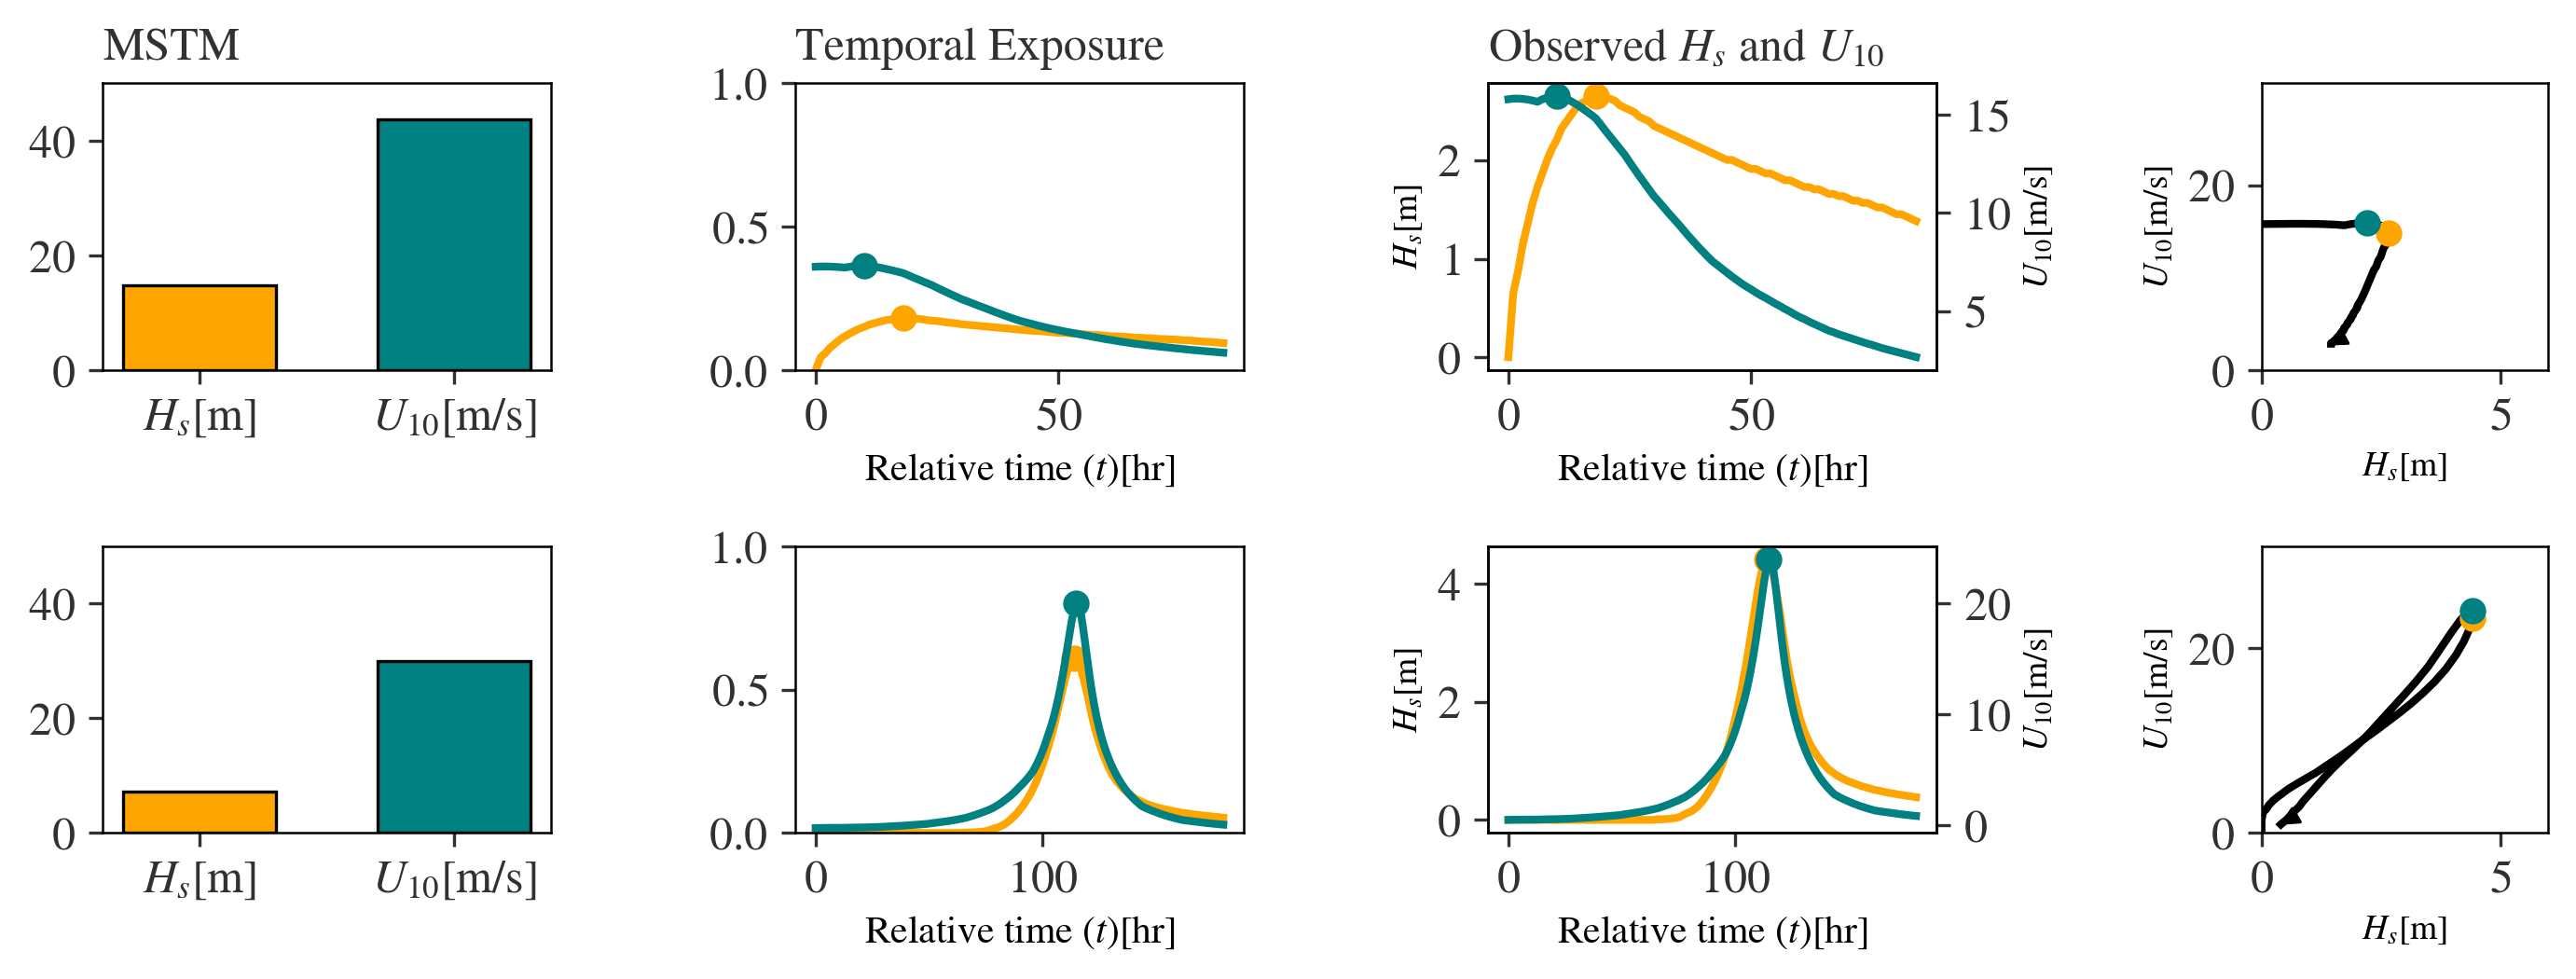

In [ ]:
# pos_list_pwe = [4567,5006,5923,6078,6111]
pos_list_pwe = [5006,6078,6111]

fig, axes = plt.subplots(
    2,
    4,
    figsize=(4 * 4*0.6, 3 * 2*0.6),
)
fig.subplots_adjust(hspace=0.5, wspace=0.5)
mstm_list = mstme_condition.stm.data[:, 0:3].T
title_size=12
axes[0, 0].set_title("MSTM",size=title_size)
axes[0, 1].set_title("Temporal Exposure",size=title_size)
axes[0, 2].set_title("Observed $H_s$ and $U_{10}$",size=title_size)
for i in range(2):
    ds = xr.load_dataset(f"./data/exp_series/{i+3:03d}.nc")
    ni = pos_list_pwe[0]
    t = ds["time"]
    x = np.arange(t.size)
    yh = ds["hs"].isel(node=ni)
    yu = ds["UV_10m"].isel(node=ni)
    idx_h = yh.argmax()
    idx_u = yu.argmax()
    mstm = mstm_list[i]

    ##
    axes[i, 0].set_ylim(0, 50)
    axes[i, 0].bar(
        [f"{STM.H.name()}[m]", f"{STM.U.name()}[m/s]"],
        height=mstm,
        width=0.6,
        color=["orange", "teal"],
    )

    ##
    axes[i, 1].set_ylim(0, 1)
    axes[i, 1].plot(x, yh, c="orange", label=STM.H.name())
    axes[i, 1].plot(x, yu, c="teal", label=STM.U.name())

    axes[i, 1].scatter(x[idx_h], yh[idx_h], c="orange")
    axes[i, 1].scatter(x[idx_u], yu[idx_u], c="teal")

    # axes[i,1].xaxis.set_major_formatter(
    #     mdates.ConciseDateFormatter(
    #         # axes[i,1].xaxis.get_major_locator(),
    #         mdates.HourLocator(),
    #         show_offset=False))
    # for label in axes[i,1].get_xticklabels(which='major'):
    #     label.set(rotation=30, horizontalalignment='right')
    # axes[i, 1].tick_params(
    #     axis="x",  # changes apply to the x-axis
    #     which="both",  # both major and minor ticks are affected
    #     bottom=False,  # ticks along the bottom edge are off
    #     top=False,  # ticks along the top edge are off
    #     labelbottom=False,
    # )
    # axes[i, 1].set_ylabel("TE")
    axes[i, 1].set_xlabel(r"Relative time ($t$)[hr]",size=10)
    # axes[i, 1].legend()

    ##
    axes[i, 2].plot(x, mstm[0] * yh, c="orange", label=STM.H.name())
    ax2 = axes[i, 2].twinx()
    ax2.plot(x, mstm[1] * yu, c="teal", label=STM.U.name())

    axes[i, 2].scatter(x[idx_h], mstm[0] * yh[idx_h], c="orange")
    ax2.scatter(x[idx_u], mstm[1] * yu[idx_u], c="teal")

    # axes[i,2].xaxis.set_major_formatter(
    #     mdates.ConciseDateFormatter(
    #         mdates.HourLocator(),
    #         # ax.xaxis.get_major_locator(),
    #         show_offset=False))
    # for label in axes[i,2].get_xticklabels(which='major'):
    #     label.set(rotation=30, horizontalalignment='right')
    # axes[i,2].legend()
    # ax2.legend()
    axes[i, 2].tick_params(
        axis="x",  # changes apply to the x-axis
        which="both",  # both major and minor ticks are affected
        top=False,  # ticks along the top edge are off

    )
    axes[i, 2].set_ylabel(f"{STM.H.name()}[{STM.H.unit()}]",size=9)
    axes[i, 2].set_xlabel(r"Relative time ($t$)[hr]",size=10)
    ax2.set_ylabel(f"{STM.U.name()}[{STM.U.unit()}]",size=9)


    axes[i,3].set_aspect(6/31)
    axes[i,3].set_xlim(0, 6)
    axes[i,3].set_ylim(0, 31)
    axes[i,3].plot(mstm[0] * yh[:-3], mstm[1] * yu[:-3], c="k", zorder=-1)
    axes[i,3].annotate(
        "",
        xy=(mstm[0] * yh[-1], mstm[1] * yu[-1]),
        xytext=(mstm[0] * yh[-3], mstm[1] * yu[-3]),
        arrowprops=dict(arrowstyle="-|>", fc="k"),
    )
    axes[i,3].scatter(mstm[0] * yh[idx_h], mstm[1] * yu[idx_h], c="orange")
    axes[i,3].scatter(mstm[0] * yh[idx_u], mstm[1] * yu[idx_u], c="teal")
    axes[i,3].set_xlabel(f"{STM.H.name()}[{STM.H.unit()}]",size=9)
    axes[i,3].set_ylabel(f"{STM.U.name()}[{STM.U.unit()}]",size=9)
fig.tight_layout()
plt.savefig("./output-new/common/example_2_events.png", bbox_inches="tight")
plt.savefig("./output-new/common/example_2_events.pdf", bbox_inches="tight")

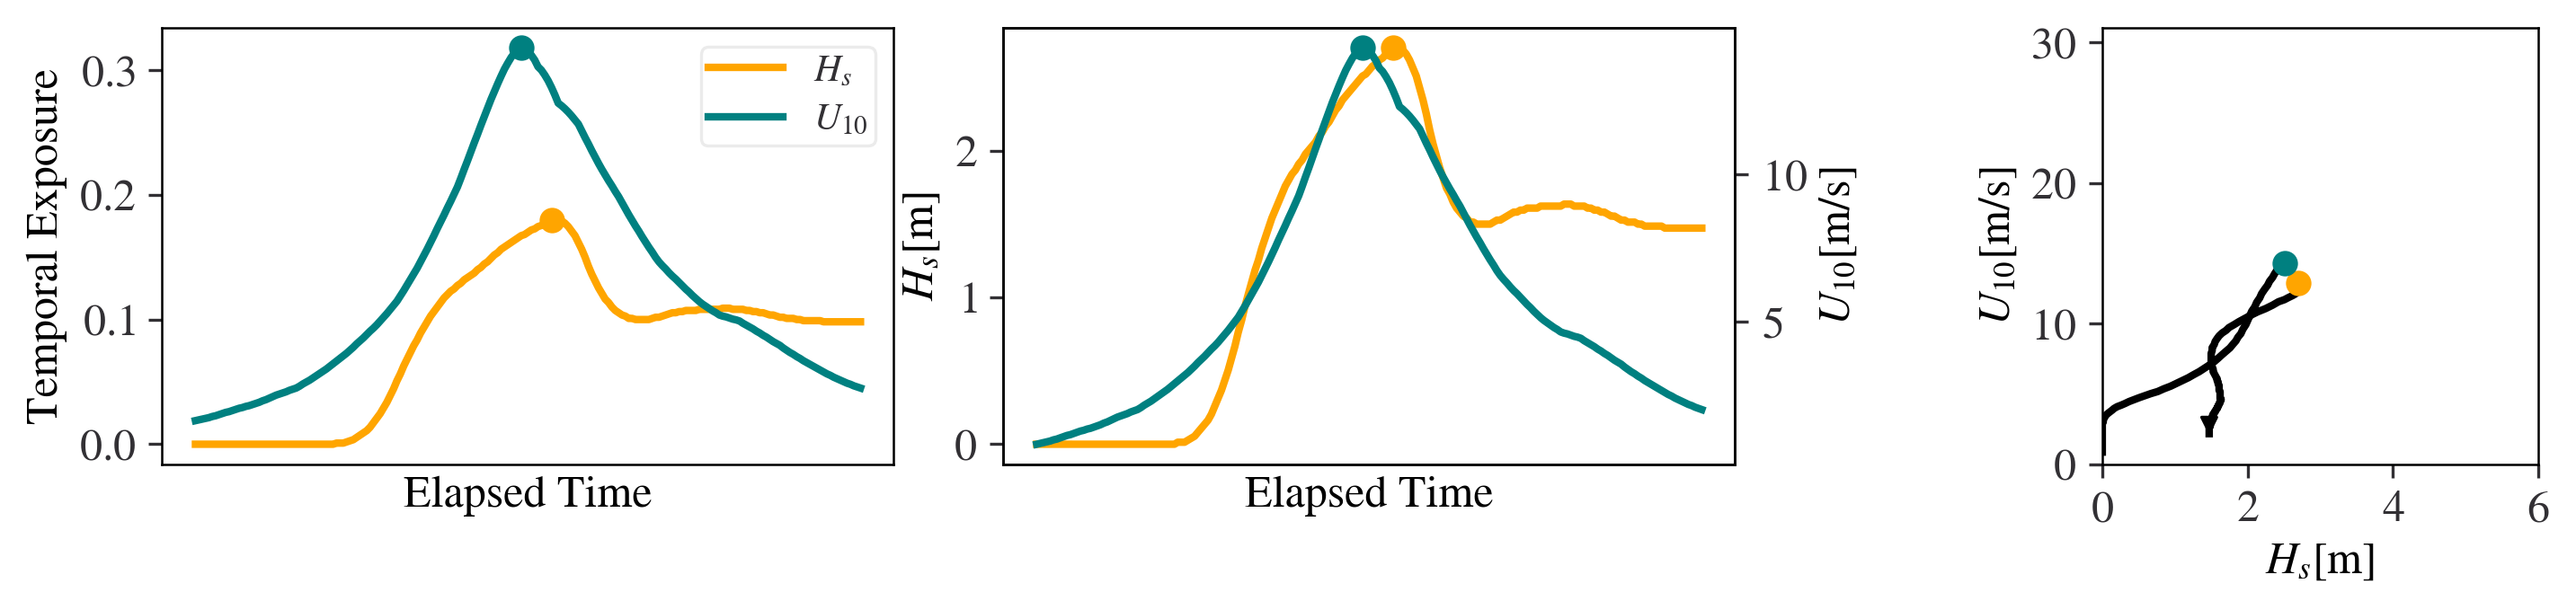

In [ ]:
fig, axes = plt.subplots(
    1,
    4,
    figsize=(4 * 3*0.8, 3*0.7),
    facecolor="white",
    gridspec_kw=dict(width_ratios=[6, 6, 0, 6],wspace=0.2),
)
fig.subplots_adjust(right=1.1)
axes[2].remove()
ni = 20457 + nni
x = ds["time"]
yh = ds["hs"].isel(node=ni)
yu = ds["UV_10m"].isel(node=ni)
idx_h = yh.argmax()
idx_u = yu.argmax()

###
axes[0].plot(x, yh, c="orange", label=STM.H.name())
axes[0].plot(x, yu, c="teal", label=STM.U.name())
# axes[0].set_
axes[0].scatter(x[idx_h], yh[idx_h], c="orange")
axes[0].scatter(x[idx_u], yu[idx_u], c="teal")

axes[0].tick_params(
        axis="x",  # changes apply to the x-axis
        which="both",  # both major and minor ticks are affected
        bottom=False,  # ticks along the bottom edge are off
        top=False,  # ticks along the top edge are off
        labelbottom=False,
    )
axes[0].set_xlabel(r"Relative time ($t$)")
axes[0].set_ylabel("Temporal Exposure")
axes[0].legend()

###
mstm = [15, 45]
axes[1].plot(x, mstm[0] * yh, c="orange", label=STM.H.name())
ax2 = axes[1].twinx()
ax2.plot(x, mstm[1] * yu, c="teal", label=STM.U.name())

axes[1].scatter(x[idx_h], mstm[0] * yh[idx_h], c="orange")
ax2.scatter(x[idx_u], mstm[1] * yu[idx_u], c="teal")


# axes[1].xaxis.set_major_formatter(
#     mdates.ConciseDateFormatter(ax.xaxis.get_major_locator())
# )
# for label in axes[1].get_xticklabels(which="major"):
#     label.set(rotation=20, horizontalalignment="right")
# axes[1].legend()
# ax2.legend()
axes[1].tick_params(
        axis="x",  # changes apply to the x-axis
        which="both",  # both major and minor ticks are affected
        bottom=False,  # ticks along the bottom edge are off
        top=False,  # ticks along the top edge are off
        labelbottom=False,
    )
axes[1].set_xlabel(r"Relative time ($t$)")
axes[1].set_ylabel(f"{STM.H.name()}[{STM.H.unit()}]")
ax2.set_ylabel(f"{STM.U.name()}[{STM.U.unit()}]")

###
axes[3].set_aspect(6/31)
axes[3].set_xlim(0, 6)
axes[3].set_ylim(0, 31)
axes[3].plot(mstm[0] * yh[:-3], mstm[1] * yu[:-3], c="k", zorder=-1)
axes[3].annotate(
    "",
    xy=(mstm[0] * yh[-1], mstm[1] * yu[-1]),
    xytext=(mstm[0] * yh[-3], mstm[1] * yu[-3]),
    arrowprops=dict(arrowstyle="-|>", fc="k"),
)
axes[3].scatter(mstm[0] * yh[idx_h], mstm[1] * yu[idx_h], c="orange")
axes[3].scatter(mstm[0] * yh[idx_u], mstm[1] * yu[idx_u], c="teal")
axes[3].set_xlabel(f"{STM.H.name()}[{STM.H.unit()}]")
axes[3].set_ylabel(f"{STM.U.name()}[{STM.U.unit()}]")
# fig.tight_layout()

plt.savefig('./output-new/common/example_series_combined.png',bbox_inches='tight')
plt.savefig('./output-new/common/example_series_combined.pdf',bbox_inches='tight')

## Quantize

In [ ]:
loc_i = 0
num_events_ext = np.count_nonzero(mstme.is_e_any)
exp_series_ext = [
    ds_exp_series[idx].isel(node=pos_list_5loc[loc_i])[['hs','UV_10m']] for idx in np.where(mstme.is_e_any)[0]
]
stm_ext = mstme.stm[:, mstme.is_e_any]
exp_array, exp_unique = es.quantize_exp(exp_series_ext, num_events_ext, res, use_temporal)
exp_array *= es.get_mask(res, {"type": mask_type, "threshold": mask_threshold})

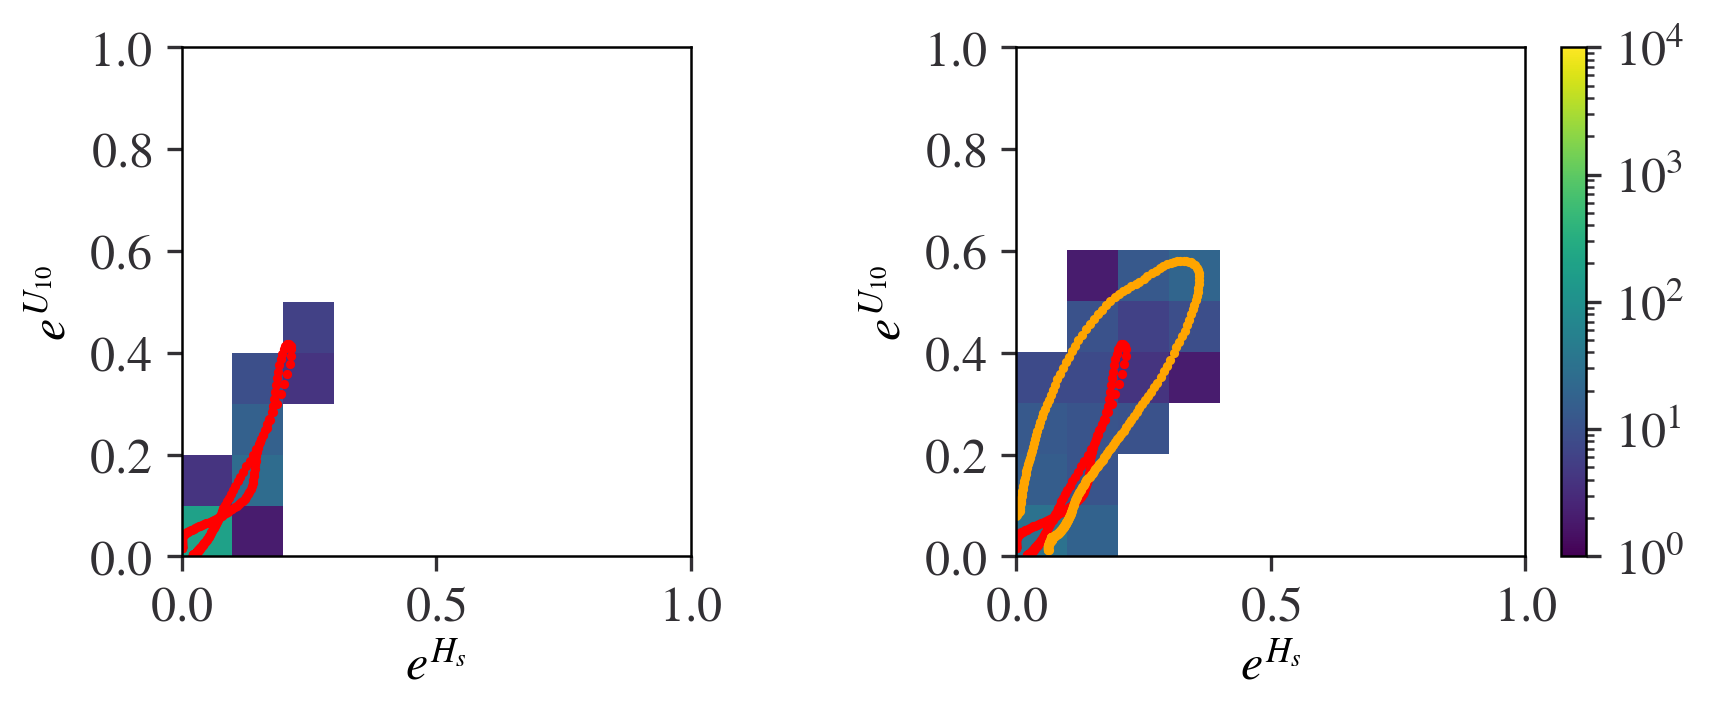

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(6, 2.5), facecolor="white")
ei = 1
dei=2

axes[0].set_aspect('equal')
axes[0].set_xlabel(r"$e^{H_s}$")
axes[0].set_ylabel(r"$e^{U_{10}}$")
_,_,_,im=axes[0].hist2d(
    exp_series_ext[ei]["hs"].values.tolist(),
    exp_series_ext[ei]["UV_10m"].values.tolist(),
    range=[[0,1],[0,1]],
    bins=10,
    norm=colors.LogNorm(1e0,1e4)
)
axes[0].scatter(
    exp_series_ext[ei]["hs"].values.tolist(),
    exp_series_ext[ei]["UV_10m"].values.tolist(),
    s=2,
    c='red',
)

axes[1].set_aspect("equal")
axes[1].set_xlabel(r"$e^{H_s}$")
axes[1].set_ylabel(r"$e^{U_{10}}$")
# _, _, _, im = axes[1].hist2d(
#     exp_series_ext[ei]["hs"].values.tolist(),
#     exp_series_ext[ei]["UV_10m"].values.tolist(),
#     range=[[0, 1], [0, 1]],
#     bins=10,
#     norm=colors.LogNorm(1e0, 1e4),
# )

im=axes[1].imshow(
    np.abs(exp_array[ei] - exp_array[ei + dei]).T,
    origin="lower",
    extent=(0,1,0,1),
    norm=colors.LogNorm(1e0, 1e4),
)

axes[1].scatter(
    exp_series_ext[ei]["hs"].values.tolist(),
    exp_series_ext[ei]["UV_10m"].values.tolist(),
    s=2,
    c="red",
    marker='o',
    label=f"Event #{ei}"
)
axes[1].scatter(
    exp_series_ext[ei+dei]["hs"].values.tolist(),
    exp_series_ext[ei+dei]["UV_10m"].values.tolist(),
    s=2,
    c="orange",
    marker='o',
    label=f"Event #{ei+dei}"
)

fig.tight_layout()
# ax.legend()
plt.colorbar(im,ax=axes[1])

plt.savefig(path_out / f"quantize_example_and_diff{loc_i}.pdf", bbox_inches="tight")
plt.savefig(path_out / f"quantize_example_and_diff{loc_i}.png", bbox_inches="tight")